In [609]:
import torch
import numpy as np
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm
torch.cuda.is_available()

True

In [610]:
CVAP_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAP_SD/CVAP_all_SD.csv', encoding= 'utf-8',sep="\t")
df0 = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df0['class'] = 'Phrase'
#df0.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']

CVAS_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAS_SD/CVAS_all.csv', encoding= 'utf-8',sep="\t")
df1 = CVAS_all_SD_df.drop(['Valence_SD', 'Arousal_SD'], axis= 1)
df1['class'] = 'Text'
df1.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


CVAW_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAW_SD/CVAW_all_SD.csv', encoding= 'utf-8',sep="\t")
df2 = CVAW_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df2['class'] = 'Word'
df2.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


#df = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
print(df0.loc[1],df1.loc[1],df2.loc[1])

Phrase            更加小心
Valence_Mean     5.111
Arousal_Mean     7.188
class           Phrase
Name: 1, dtype: object Phrase          每一樣都美好得不可思議
Valence_Mean           7.75
Arousal_Mean            7.4
class                  Text
Name: 1, dtype: object Phrase            不平
Valence_Mean     3.6
Arousal_Mean     5.8
class           Word
Name: 1, dtype: object


In [611]:
df = pd.concat([df0,df1,df2], axis= 0).reset_index(drop= True)
#df = df0
df.loc[0]


Phrase             怪八卦
Valence_Mean      3.45
Arousal_Mean     4.383
class           Phrase
Name: 0, dtype: object

In [613]:

# 提取特徵和標籤
#X = df[['Valence_Mean', 'Arousal_Mean']]
#y = df['Phrase'] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱
x = df['Phrase']
y = df[['Valence_Mean','Arousal_Mean']] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱

# 將數據集分成訓練集和測試集，以 80:20 的比例分割
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(x_train)


3209    還輪得到他們一天到晚在網上放屁
7666                 困在
9968                 貶損
3643        展現自己健美肉體以敬神
6606                 許可
             ...       
5734                 深思
5191                 妄想
5390                 放縱
860                異常嚴格
7270                 故意
Name: Phrase, Length: 7758, dtype: object


In [614]:
# bert = AutoModel.from_pretrained('bert-base-chinese', return_dict=False)
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

from transformers import (
  BertTokenizerFast,
  AutoModel,
)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese', return_dict=False)

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dens

In [616]:
train_idx = x_train.dropna().index
test_idx = x_test.dropna().index

train_tokens = tokenizer.batch_encode_plus(x_train[train_idx].to_list(),
                                           max_length = 50,
                                           #pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
test_tokens = tokenizer.batch_encode_plus(x_test[test_idx].to_list(),
                                           max_length = 50,
                                          # pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
#print(y_train['Valence_Mean'])
# y_train = y_train.reset_index(drop = True)
#y_train.loc[0]

In [617]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
# print([i for i in y_train['Valence_Mean']])
# train_y = torch.tensor([i for i in y_train['Valence_Mean']])
train_y = torch.tensor([(i, j) for i, j in zip(y_train['Valence_Mean'], y_train['Arousal_Mean'])])
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
#test_y = torch.tensor([i for i in y_test['Valence_Mean']])
test_y = torch.tensor([(i, j) for i, j in zip(y_test['Valence_Mean'], y_test['Arousal_Mean'])])

In [618]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [619]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, 
                         sampler = train_sampler,
                         batch_size = 32)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_data)
testloader = DataLoader(test_data, 
                         sampler = test_sampler,
                         batch_size = 32)

In [620]:
for param in bert.parameters():
    param.requires_grad = False

In [621]:
from torch import nn
from transformers import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [622]:
# class BertRegressor(nn.Module):
#     def __init__(self, bert):
#         super().__init__()
#         self.bert = bert
#         self.fc1 = nn.Linear(768, 1)  # output one continuous value
    
#     def forward(self, sent_id, mask):
#         _, cls_hs = self.bert(sent_id, attention_mask=mask)
#         return self.fc1(cls_hs).squeeze()  # remove the last dimension of size 1
    
class BertRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768, 128)  # add a linear layer with output size 128
        self.relu = nn.ReLU()  # add ReLU activation function
        self.fc2 = nn.Linear(128, 128)  # output one continuous value
        self.fc3 = nn.Linear(128, 2)  # output one continuous value

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)  # apply ReLU activation
        x = self.fc2(x)
        x = self.relu(x)  # apply ReLU activation
        # return self.fc3(x).squeeze()  # remove the last dimension of size 1
        return self.fc3(x)


In [623]:
model = BertRegressor(bert)
model = model.cuda()

In [624]:
optimizer = AdamW(model.parameters(), lr=1e-5)

c:\Program Files\Python\38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [625]:
# def loss_fn(outputs, targets):
#     return F.mse_loss(outputs, targets)

In [626]:
#criterion = nn.MSELoss()
criterion = nn.MSELoss(reduction='sum')

In [627]:
from tqdm import tqdm

In [628]:
epochs = 500
losses = []
for e in range(epochs):   
    train_loss = 0.0
    for batch in tqdm(trainloader):
        batch = [i.cuda() for i in batch]
        sent_id, masks, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, masks)
        loss = criterion(preds, labels)
        train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    losses.append(train_loss / len(trainloader))
    print(f'Epoch:{e+1}\t\tTraining Loss: {train_loss / len(trainloader)}')

100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:1		Training Loss: 1509.5044407471707


100%|██████████| 243/243 [00:17<00:00, 13.89it/s]


Epoch:2		Training Loss: 1093.8513577936117


100%|██████████| 243/243 [00:17<00:00, 13.85it/s]


Epoch:3		Training Loss: 634.5078156396685


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:4		Training Loss: 273.60759838716484


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:5		Training Loss: 150.94008645893615


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:6		Training Loss: 144.79409133848338


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:7		Training Loss: 141.46163857228473


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:8		Training Loss: 138.82222085332674


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:9		Training Loss: 136.30456582214606


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:10		Training Loss: 133.823174292168


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:11		Training Loss: 131.38113142727823


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:12		Training Loss: 129.04632376839595


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:13		Training Loss: 126.50932355967078


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:14		Training Loss: 124.00508001508045


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:15		Training Loss: 121.71059062942065


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:16		Training Loss: 119.18591820359721


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:17		Training Loss: 116.620739611088


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:18		Training Loss: 114.34983696957184


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:19		Training Loss: 112.06533913945955


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:20		Training Loss: 110.17439577707047


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:21		Training Loss: 108.31142354894567


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:22		Training Loss: 106.5099584634412


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:23		Training Loss: 104.86192610626848


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:24		Training Loss: 103.50129399868686


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:25		Training Loss: 102.28652900727198


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:26		Training Loss: 101.20257405096612


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:27		Training Loss: 100.25413225903924


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:28		Training Loss: 99.3413731767317


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:29		Training Loss: 98.56162899315602


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:30		Training Loss: 97.78794783917965


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:31		Training Loss: 97.07246361249759


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:32		Training Loss: 96.47634931650671


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:33		Training Loss: 95.95843052177273


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:34		Training Loss: 95.49272860617305


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:35		Training Loss: 94.92458848992493


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:36		Training Loss: 94.52454963338718


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:37		Training Loss: 94.07459282580717


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:38		Training Loss: 93.81753200954861


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:39		Training Loss: 93.39804909160598


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:40		Training Loss: 93.11167647122356


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:41		Training Loss: 92.770127284674


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:42		Training Loss: 92.45001784273626


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:43		Training Loss: 92.17602413475758


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:44		Training Loss: 91.87106045381522


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:45		Training Loss: 91.68052293439952


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:46		Training Loss: 91.40369735529393


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:47		Training Loss: 91.1243447511775


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:48		Training Loss: 90.8714829276128


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:49		Training Loss: 90.62387147754308


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:50		Training Loss: 90.37646387045275


100%|██████████| 243/243 [00:17<00:00, 13.87it/s]


Epoch:51		Training Loss: 90.17181036992328


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:52		Training Loss: 90.0165700245296


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:53		Training Loss: 89.69204483503177


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:54		Training Loss: 89.52341634648327


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:55		Training Loss: 89.36898809990275


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:56		Training Loss: 89.16571880073704


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:57		Training Loss: 88.97325146051101


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:58		Training Loss: 88.77206519797996


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:59		Training Loss: 88.577144497216


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:60		Training Loss: 88.38959755917145


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:61		Training Loss: 88.19979239883737


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:62		Training Loss: 87.97870655609256


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:63		Training Loss: 87.84241931428635


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:64		Training Loss: 87.80679999457465


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:65		Training Loss: 87.58238173119815


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:66		Training Loss: 87.31197330490552


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:67		Training Loss: 87.15910957870169


100%|██████████| 243/243 [00:17<00:00, 14.02it/s]


Epoch:68		Training Loss: 87.11964947107889


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:69		Training Loss: 86.85933143709913


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:70		Training Loss: 86.73896106672876


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:71		Training Loss: 86.59513735673065


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:72		Training Loss: 86.37743427135327


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:73		Training Loss: 86.37119434497974


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:74		Training Loss: 86.18109118300701


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:75		Training Loss: 85.99267766505112


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:76		Training Loss: 85.8740329349973


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:77		Training Loss: 85.7609767207393


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:78		Training Loss: 85.63965851583599


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:79		Training Loss: 85.54706133932734


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:80		Training Loss: 85.32331043604471


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:81		Training Loss: 85.19933870103624


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:82		Training Loss: 85.09301658912942


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:83		Training Loss: 84.92231161800431


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:84		Training Loss: 84.80977140826944


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:85		Training Loss: 84.70357872919782


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:86		Training Loss: 84.56800848564494


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:87		Training Loss: 84.48742038428539


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:88		Training Loss: 84.38718805195373


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:89		Training Loss: 84.1860542925297


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:90		Training Loss: 84.21744436099206


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:91		Training Loss: 84.04582589545858


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:92		Training Loss: 83.96162996959293


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:93		Training Loss: 83.76602058253661


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:94		Training Loss: 83.65682568962191


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:95		Training Loss: 83.51383623664762


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:96		Training Loss: 83.5071010511108


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:97		Training Loss: 83.32447493125382


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:98		Training Loss: 83.2399964509187


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:99		Training Loss: 83.12263196780358


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:100		Training Loss: 83.06442554301195


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:101		Training Loss: 82.90767194017951


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:102		Training Loss: 82.79857917283297


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:103		Training Loss: 82.7290274223673


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:104		Training Loss: 82.58641279872062


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:105		Training Loss: 82.49650961479533


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:106		Training Loss: 82.35662947760687


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:107		Training Loss: 82.27909953113446


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:108		Training Loss: 82.20552219971708


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:109		Training Loss: 82.06116324687692


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:110		Training Loss: 81.96418189217525


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:111		Training Loss: 81.86432724626957


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:112		Training Loss: 81.75314048484519


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:113		Training Loss: 81.61032128039702


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:114		Training Loss: 81.60438353927047


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:115		Training Loss: 81.44093459329487


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:116		Training Loss: 81.27941191245499


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:117		Training Loss: 81.24307192892695


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:118		Training Loss: 81.1162258038305


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:119		Training Loss: 81.09901808122548


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:120		Training Loss: 80.94647964037985


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:121		Training Loss: 80.77523752691324


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:122		Training Loss: 80.77996597760989


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:123		Training Loss: 80.64235957267353


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:124		Training Loss: 80.52029619099181


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:125		Training Loss: 80.49057892222463


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:126		Training Loss: 80.327489656676


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:127		Training Loss: 80.24461947939524


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:128		Training Loss: 80.10858453350302


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:129		Training Loss: 80.12990937409577


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:130		Training Loss: 79.9288230707616


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:131		Training Loss: 79.98054191997512


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:132		Training Loss: 79.79168425665961


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:133		Training Loss: 79.76994576473786


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:134		Training Loss: 79.58238173119815


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:135		Training Loss: 79.49937872239101


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:136		Training Loss: 79.45293288368256


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:137		Training Loss: 79.37235087327997


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:138		Training Loss: 79.26824539875297


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:139		Training Loss: 79.19245315677344


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:140		Training Loss: 79.07144383246026


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:141		Training Loss: 78.98586339126399


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:142		Training Loss: 78.87262493494607


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:143		Training Loss: 78.80376611717443


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:144		Training Loss: 78.83801936710813


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:145		Training Loss: 78.67008166058073


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:146		Training Loss: 78.53650213170934


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:147		Training Loss: 78.46940812161921


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:148		Training Loss: 78.40227097248344


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:149		Training Loss: 78.39282791702836


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:150		Training Loss: 78.23875103075318


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:151		Training Loss: 78.1040806711456


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:152		Training Loss: 78.05231705025881


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:153		Training Loss: 77.89278336513189


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:154		Training Loss: 77.94347781899535


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:155		Training Loss: 77.86885843944157


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:156		Training Loss: 77.74813999756864


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:157		Training Loss: 77.65956721678683


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:158		Training Loss: 77.61798552524897


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:159		Training Loss: 77.51234363037862


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:160		Training Loss: 77.37772958072615


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:161		Training Loss: 77.34479855509943


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:162		Training Loss: 77.29034194632322


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:163		Training Loss: 77.17771187927497


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:164		Training Loss: 77.13691350363901


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:165		Training Loss: 76.99481978239837


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:166		Training Loss: 76.91204414838626


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:167		Training Loss: 76.8834105597602


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:168		Training Loss: 76.78700185705114


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:169		Training Loss: 76.64556641441314


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:170		Training Loss: 76.68270495693379


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:171		Training Loss: 76.56221798712335


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:172		Training Loss: 76.41960214685511


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:173		Training Loss: 76.41748597886827


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:174		Training Loss: 76.31230216948583


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:175		Training Loss: 76.24367834805462


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:176		Training Loss: 76.19522980898006


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:177		Training Loss: 76.07962049476404


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:178		Training Loss: 76.08131462065771


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:179		Training Loss: 75.96484575938786


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:180		Training Loss: 75.87558372717335


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:181		Training Loss: 75.80659929126378


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:182		Training Loss: 75.76920725190591


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:183		Training Loss: 75.64591761773505


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:184		Training Loss: 75.58293817465197


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:185		Training Loss: 75.45453319628052


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:186		Training Loss: 75.45205383928715


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:187		Training Loss: 75.3293611973892


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:188		Training Loss: 75.24678547392166


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:189		Training Loss: 75.22650009123876


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:190		Training Loss: 75.22118952244888


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:191		Training Loss: 75.08515558909977


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:192		Training Loss: 74.99390797556183


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:193		Training Loss: 75.0072363394278


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:194		Training Loss: 74.83661080191655


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:195		Training Loss: 74.79624552785614


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:196		Training Loss: 74.7436733952275


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:197		Training Loss: 74.58698553705412


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:198		Training Loss: 74.60532016518675


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:199		Training Loss: 74.53496551513672


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:200		Training Loss: 74.37881902215902


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:201		Training Loss: 74.346608676047


100%|██████████| 243/243 [00:17<00:00, 14.00it/s]


Epoch:202		Training Loss: 74.34791885187596


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:203		Training Loss: 74.16530365806548


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:204		Training Loss: 74.12785022248947


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:205		Training Loss: 74.1082651428725


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:206		Training Loss: 74.03150820634002


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:207		Training Loss: 73.9225112224312


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:208		Training Loss: 73.97469625747743


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:209		Training Loss: 73.75968309881266


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:210		Training Loss: 73.74672865377042


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:211		Training Loss: 73.63723293351538


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:212		Training Loss: 73.49395361064393


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:213		Training Loss: 73.51320725115238


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:214		Training Loss: 73.45537909362542


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:215		Training Loss: 73.38604799121495


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:216		Training Loss: 73.40003364468798


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:217		Training Loss: 73.266769927225


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:218		Training Loss: 73.20554595130952


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:219		Training Loss: 73.04515129057958


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:220		Training Loss: 72.97338419784734


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:221		Training Loss: 73.02523081587175


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:222		Training Loss: 72.89001169714908


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:223		Training Loss: 72.87010153625238


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:224		Training Loss: 72.75042291335117


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:225		Training Loss: 72.72000162886003


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:226		Training Loss: 72.65543462023322


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:227		Training Loss: 72.62927847340274


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:228		Training Loss: 72.4982191015173


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:229		Training Loss: 72.47923451490362


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:230		Training Loss: 72.23435204117386


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:231		Training Loss: 72.41728098206069


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:232		Training Loss: 72.29901184270412


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:233		Training Loss: 72.21805735772529


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:234		Training Loss: 72.10579996933171


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:235		Training Loss: 72.08552314224558


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:236		Training Loss: 72.00007828763484


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:237		Training Loss: 71.86212004359366


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:238		Training Loss: 71.87329095283162


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:239		Training Loss: 71.77599689499341


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:240		Training Loss: 71.72741691369579


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:241		Training Loss: 71.63415569729275


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:242		Training Loss: 71.62370879561813


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:243		Training Loss: 71.48651175636323


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:244		Training Loss: 71.47999495832028


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:245		Training Loss: 71.40410108527038


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:246		Training Loss: 71.2763176121339


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:247		Training Loss: 71.2646399760933


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:248		Training Loss: 71.2142205885899


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:249		Training Loss: 71.17629993893972


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:250		Training Loss: 71.09895152025263


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:251		Training Loss: 71.06627364609957


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:252		Training Loss: 71.06904058888125


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:253		Training Loss: 70.8701090557585


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:254		Training Loss: 70.79600592405217


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:255		Training Loss: 70.74842445153759


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:256		Training Loss: 70.63729247732908


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:257		Training Loss: 70.5852871804571


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:258		Training Loss: 70.58838527977711


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:259		Training Loss: 70.44956091107655


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:260		Training Loss: 70.46409996252491


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:261		Training Loss: 70.47007415520311


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:262		Training Loss: 70.2949425968123


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:263		Training Loss: 70.24479237309208


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:264		Training Loss: 70.19961657739961


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:265		Training Loss: 70.10903038213283


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:266		Training Loss: 70.06817487237875


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:267		Training Loss: 69.9913148055842


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:268		Training Loss: 69.91837165581346


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:269		Training Loss: 69.82544334631397


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:270		Training Loss: 69.81122796329451


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:271		Training Loss: 69.80640774008668


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:272		Training Loss: 69.65445224934645


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:273		Training Loss: 69.67598085442688


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:274		Training Loss: 69.51765564341603


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:275		Training Loss: 69.45347005742077


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:276		Training Loss: 69.39115492895307


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:277		Training Loss: 69.40446792414158


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:278		Training Loss: 69.33043414771312


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:279		Training Loss: 69.1763348206571


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:280		Training Loss: 69.1751780176359


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:281		Training Loss: 69.18223367698889


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:282		Training Loss: 69.12368592313288


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:283		Training Loss: 69.02282951103807


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:284		Training Loss: 68.98150520167724


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:285		Training Loss: 68.86084073855554


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:286		Training Loss: 68.849041974103


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:287		Training Loss: 68.73516360624338


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:288		Training Loss: 68.71182138733413


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:289		Training Loss: 68.60501522488065


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:290		Training Loss: 68.57630961225847


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:291		Training Loss: 68.52822966242033


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:292		Training Loss: 68.4997253888919


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:293		Training Loss: 68.36809902426637


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:294		Training Loss: 68.29082930922017


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:295		Training Loss: 68.32779155935279


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:296		Training Loss: 68.17826631334093


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:297		Training Loss: 68.20030152748642


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:298		Training Loss: 68.15065529905719


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:299		Training Loss: 68.05342507068022


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:300		Training Loss: 67.98885726928711


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:301		Training Loss: 68.00135942937906


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:302		Training Loss: 67.85261796237019


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:303		Training Loss: 67.81232632923519


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:304		Training Loss: 67.74352930014025


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:305		Training Loss: 67.64986319208342


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:306		Training Loss: 67.63890901416417


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:307		Training Loss: 67.58630843613864


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:308		Training Loss: 67.49683220003858


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:309		Training Loss: 67.48556934560767


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:310		Training Loss: 67.43345929369514


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:311		Training Loss: 67.39609989119165


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:312		Training Loss: 67.29305238292051


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:313		Training Loss: 67.20658684561772


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:314		Training Loss: 67.1870515532945


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:315		Training Loss: 67.10987863422912


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:316		Training Loss: 66.98442862553851


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:317		Training Loss: 67.02326835035787


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:318		Training Loss: 66.91720223132475


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:319		Training Loss: 66.86470171453531


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:320		Training Loss: 66.86361892919972


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:321		Training Loss: 66.77756237296902


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:322		Training Loss: 66.63467641131868


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:323		Training Loss: 66.59917373029293


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:324		Training Loss: 66.58194845694082


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:325		Training Loss: 66.49079847924503


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:326		Training Loss: 66.42332331339519


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:327		Training Loss: 66.44179450141058


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:328		Training Loss: 66.3271296308855


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:329		Training Loss: 66.18014753993155


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:330		Training Loss: 66.23913907023615


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:331		Training Loss: 66.16876135932074


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:332		Training Loss: 66.01579127684542


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:333		Training Loss: 66.05493234705042


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:334		Training Loss: 65.91513976736815


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:335		Training Loss: 65.93962216475373


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:336		Training Loss: 65.80145089420272


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:337		Training Loss: 65.77752608624996


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:338		Training Loss: 65.73381522849753


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:339		Training Loss: 65.65958666703338


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:340		Training Loss: 65.65053006552866


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:341		Training Loss: 65.60521820445119


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:342		Training Loss: 65.46032039815016


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:343		Training Loss: 65.54165451614945


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:344		Training Loss: 65.45621124707132


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:345		Training Loss: 65.32188299359608


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:346		Training Loss: 65.27222574493031


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:347		Training Loss: 65.27764044867621


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:348		Training Loss: 65.13934460392704


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:349		Training Loss: 65.08271988919734


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:350		Training Loss: 65.01876416618441


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:351		Training Loss: 65.02673206407837


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:352		Training Loss: 64.91275046391742


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:353		Training Loss: 64.85690013273263


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:354		Training Loss: 64.83282837259426


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:355		Training Loss: 64.77383578265155


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:356		Training Loss: 64.66078470960076


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:357		Training Loss: 64.66999272162042


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:358		Training Loss: 64.58550549730842


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:359		Training Loss: 64.63704336817862


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:360		Training Loss: 64.467670173802


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:361		Training Loss: 64.46059602965053


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:362		Training Loss: 64.34723890956046


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:363		Training Loss: 64.3494997848699


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:364		Training Loss: 64.33937801157006


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:365		Training Loss: 64.23491335896307


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:366		Training Loss: 64.25318933808755


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:367		Training Loss: 64.04511943864233


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:368		Training Loss: 64.01662102844489


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:369		Training Loss: 63.93281749050313


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:370		Training Loss: 63.96723248046121


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:371		Training Loss: 63.82586181703418


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:372		Training Loss: 63.830217180919256


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:373		Training Loss: 63.763234911632146


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:374		Training Loss: 63.721563896524565


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:375		Training Loss: 63.64977476331923


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:376		Training Loss: 63.6039860022902


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:377		Training Loss: 63.594728721022115


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:378		Training Loss: 63.62760943346063


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:379		Training Loss: 63.4901684262625


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:380		Training Loss: 63.372452943903916


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:381		Training Loss: 63.33299085044076


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:382		Training Loss: 63.314157964761364


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:383		Training Loss: 63.266207926557875


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:384		Training Loss: 63.13648147739991


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:385		Training Loss: 63.15626034520781


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:386		Training Loss: 63.10748221942917


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:387		Training Loss: 62.987074502701624


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:388		Training Loss: 62.98170610906656


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:389		Training Loss: 62.99703101954833


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:390		Training Loss: 62.89973399472335


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:391		Training Loss: 62.8171600530177


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:392		Training Loss: 62.798189422230664


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:393		Training Loss: 62.745153858828445


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:394		Training Loss: 62.56078145533432


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:395		Training Loss: 62.65916836899495


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:396		Training Loss: 62.5243129887208


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:397		Training Loss: 62.62853649123706


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:398		Training Loss: 62.435062950040084


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:399		Training Loss: 62.35894747133608


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:400		Training Loss: 62.29813808865018


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:401		Training Loss: 62.263659638141895


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:402		Training Loss: 62.25403135009263


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:403		Training Loss: 62.17795763682927


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:404		Training Loss: 62.05854405689632


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:405		Training Loss: 62.07747292224272


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:406		Training Loss: 61.994725655135795


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:407		Training Loss: 61.94750361972385


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:408		Training Loss: 62.007333009821885


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:409		Training Loss: 61.93485955446345


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:410		Training Loss: 61.764650195714374


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:411		Training Loss: 61.7358245692626


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:412		Training Loss: 61.6898869016043


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:413		Training Loss: 61.680581708994424


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:414		Training Loss: 61.53997112792215


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:415		Training Loss: 61.42972565482183


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:416		Training Loss: 61.51919579211577


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:417		Training Loss: 61.36608686564881


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:418		Training Loss: 61.44565652133016


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:419		Training Loss: 61.27848685621725


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:420		Training Loss: 61.35893546210395


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:421		Training Loss: 61.242600692152486


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:422		Training Loss: 61.36440509435081


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:423		Training Loss: 61.18329644693759


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:424		Training Loss: 61.102917227725435


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:425		Training Loss: 60.9588869707084


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:426		Training Loss: 61.00380514482412


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:427		Training Loss: 60.888975998992294


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:428		Training Loss: 60.89167003867067


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:429		Training Loss: 60.87080435105312


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:430		Training Loss: 60.8014484060154


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:431		Training Loss: 60.71756136073988


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:432		Training Loss: 60.62572392122245


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:433		Training Loss: 60.609749162148056


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:434		Training Loss: 60.539711445937925


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:435		Training Loss: 60.511694684440705


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:436		Training Loss: 60.601457230838726


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:437		Training Loss: 60.522044750888654


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:438		Training Loss: 60.42263556900338


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:439		Training Loss: 60.301152696334775


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:440		Training Loss: 60.27430212939227


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:441		Training Loss: 60.23838704113116


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:442		Training Loss: 60.23100542924041


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:443		Training Loss: 60.184874122525436


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:444		Training Loss: 60.03194867043829


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:445		Training Loss: 60.087260642660006


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:446		Training Loss: 59.97198316001107


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:447		Training Loss: 59.98143030488442


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:448		Training Loss: 59.91665582696106


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:449		Training Loss: 59.97034720432611


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:450		Training Loss: 59.771059467959304


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:451		Training Loss: 59.68792715975287


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:452		Training Loss: 59.889793246861835


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:453		Training Loss: 59.69379162101588


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:454		Training Loss: 59.59111318078061


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:455		Training Loss: 59.61250003767602


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:456		Training Loss: 59.46168562806683


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:457		Training Loss: 59.46651160471724


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:458		Training Loss: 59.49593978065522


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:459		Training Loss: 59.3020324236081


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:460		Training Loss: 59.349815007590465


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:461		Training Loss: 59.456985842543865


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:462		Training Loss: 59.19017820005064


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:463		Training Loss: 59.101163671831046


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:464		Training Loss: 59.10866669077932


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:465		Training Loss: 59.14558378462929


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:466		Training Loss: 59.05541359544291


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:467		Training Loss: 59.04577364352505


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:468		Training Loss: 58.98714385013031


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:469		Training Loss: 58.91974191704895


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:470		Training Loss: 58.87761911933805


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:471		Training Loss: 58.79011574890388


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:472		Training Loss: 58.67816218623408


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:473		Training Loss: 58.73580286237929


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:474		Training Loss: 58.745614479598686


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:475		Training Loss: 58.65242253998179


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:476		Training Loss: 58.50004405739867


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:477		Training Loss: 58.574995472597976


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:478		Training Loss: 58.46124558782381


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:479		Training Loss: 58.44766959045159


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:480		Training Loss: 58.34137520181789


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:481		Training Loss: 58.298866962699734


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:482		Training Loss: 58.26730133967145


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:483		Training Loss: 58.13881775969831


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:484		Training Loss: 58.15584991988822


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:485		Training Loss: 58.13891325271669


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:486		Training Loss: 58.157597930343066


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:487		Training Loss: 57.9838531556934


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:488		Training Loss: 58.044626769705566


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:489		Training Loss: 57.96254458643281


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:490		Training Loss: 57.836262753961506


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:491		Training Loss: 57.809717107702184


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:492		Training Loss: 57.82210231514134


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:493		Training Loss: 57.650664160771626


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:494		Training Loss: 57.67322893495913


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:495		Training Loss: 57.71328788725928


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:496		Training Loss: 57.61220374715672


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:497		Training Loss: 57.69678042062516


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:498		Training Loss: 57.6375512331111


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:499		Training Loss: 57.50021321488997


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:500		Training Loss: 57.43211181860402


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:501		Training Loss: 57.31158494360653


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:502		Training Loss: 57.32561357914175


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:503		Training Loss: 57.337332101515784


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:504		Training Loss: 57.34727704083478


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:505		Training Loss: 57.19679695882915


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:506		Training Loss: 57.13030444643625


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:507		Training Loss: 57.102395987805025


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:508		Training Loss: 57.05294872801981


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:509		Training Loss: 56.954597991189836


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:510		Training Loss: 57.0106863955902


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:511		Training Loss: 56.97458395938324


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:512		Training Loss: 56.961170793070224


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:513		Training Loss: 56.840078581507804


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:514		Training Loss: 56.842706123006685


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:515		Training Loss: 56.70116365691762


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:516		Training Loss: 56.689065862585


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:517		Training Loss: 56.70528152842581


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:518		Training Loss: 56.70775524971416


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:519		Training Loss: 56.710872249838744


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:520		Training Loss: 56.512482333085174


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:521		Training Loss: 56.48906040584109


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:522		Training Loss: 56.41316002582817


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:523		Training Loss: 56.40294803415306


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:524		Training Loss: 56.26147161099155


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:525		Training Loss: 56.28463792212216


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:526		Training Loss: 56.2916325463189


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:527		Training Loss: 56.23866567493957


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:528		Training Loss: 56.14182391382539


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:529		Training Loss: 56.31427715442799


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:530		Training Loss: 56.0779774983724


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:531		Training Loss: 55.98739602045758


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:532		Training Loss: 56.05550342135959


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:533		Training Loss: 56.11194306047856


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:534		Training Loss: 55.9470114374357


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:535		Training Loss: 55.91115373054159


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:536		Training Loss: 55.82916413609383


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:537		Training Loss: 55.881519074302645


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:538		Training Loss: 55.75664970806106


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:539		Training Loss: 55.68307805159455


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:540		Training Loss: 55.71434134024161


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:541		Training Loss: 55.626468477916326


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:542		Training Loss: 55.59797743024159


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:543		Training Loss: 55.5396594922729


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:544		Training Loss: 55.5200600486724


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:545		Training Loss: 55.45268433182328


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:546		Training Loss: 55.37617929089707


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:547		Training Loss: 55.35662267629992


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:548		Training Loss: 55.3118811909554


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:549		Training Loss: 55.284406960255815


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:550		Training Loss: 55.219873192869585


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:551		Training Loss: 55.16832401919267


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:552		Training Loss: 55.12901399557482


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:553		Training Loss: 55.04998546176486


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:554		Training Loss: 55.07547260802469


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:555		Training Loss: 54.908276012404954


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:556		Training Loss: 54.84701431337207


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:557		Training Loss: 54.89185828927123


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:558		Training Loss: 54.85486898696962


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:559		Training Loss: 54.75443467191217


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:560		Training Loss: 54.77441904672379


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:561		Training Loss: 54.721989337308905


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:562		Training Loss: 54.750254886140546


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:563		Training Loss: 54.727049878595295


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:564		Training Loss: 54.69597037044572


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:565		Training Loss: 54.563845379362384


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:566		Training Loss: 54.5532295556716


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:567		Training Loss: 54.46171494079715


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:568		Training Loss: 54.455530825956366


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:569		Training Loss: 54.403892619129074


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:570		Training Loss: 54.36737984786799


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:571		Training Loss: 54.359989213354794


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:572		Training Loss: 54.30258933801219


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:573		Training Loss: 54.20553502526303


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:574		Training Loss: 54.230198424539445


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:575		Training Loss: 54.11388109937126


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:576		Training Loss: 54.30766844258878


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:577		Training Loss: 54.07502587243853


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:578		Training Loss: 53.93226547398194


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:579		Training Loss: 54.10486909685802


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:580		Training Loss: 53.93355710221907


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:581		Training Loss: 53.877702265609926


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:582		Training Loss: 53.80138967066635


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:583		Training Loss: 53.86944798285088


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:584		Training Loss: 53.7411937164181


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:585		Training Loss: 53.778628078507786


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:586		Training Loss: 53.757210327274024


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:587		Training Loss: 53.63735219382455


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:588		Training Loss: 53.64321837405609


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:589		Training Loss: 53.718867148882076


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:590		Training Loss: 53.55374165915658


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:591		Training Loss: 53.468222331608274


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:592		Training Loss: 53.445122353824566


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:593		Training Loss: 53.513500739517525


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:594		Training Loss: 53.41415807935927


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:595		Training Loss: 53.35107824537489


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:596		Training Loss: 53.26462959163964


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:597		Training Loss: 53.355428405259374


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:598		Training Loss: 53.23914143283671


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:599		Training Loss: 53.168830196553294


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:600		Training Loss: 53.11394872783143


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:601		Training Loss: 53.08975331184795


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:602		Training Loss: 53.05765024820963


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:603		Training Loss: 53.01980500554842


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:604		Training Loss: 52.94924849835933


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:605		Training Loss: 52.91345303539386


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:606		Training Loss: 52.94273548361696


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:607		Training Loss: 52.87130064630705


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:608		Training Loss: 52.77664413766115


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:609		Training Loss: 52.77727616667257


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:610		Training Loss: 52.66513030911669


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:611		Training Loss: 52.66935432496875


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:612		Training Loss: 52.56583520708751


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:613		Training Loss: 52.57127257924021


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:614		Training Loss: 52.57260605925886


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:615		Training Loss: 52.553382736174655


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:616		Training Loss: 52.50806580060794


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:617		Training Loss: 52.53820436972159


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:618		Training Loss: 52.488693386438946


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:619		Training Loss: 52.33783652066203


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:620		Training Loss: 52.284619264641904


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:621		Training Loss: 52.314059159392684


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:622		Training Loss: 52.149692974953986


100%|██████████| 243/243 [00:17<00:00, 14.01it/s]


Epoch:623		Training Loss: 52.22992908022531


100%|██████████| 243/243 [00:17<00:00, 14.00it/s]


Epoch:624		Training Loss: 52.21162846255204


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:625		Training Loss: 52.16817836604491


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:626		Training Loss: 52.08224813830215


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:627		Training Loss: 52.0956549153897


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:628		Training Loss: 51.975038913051776


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:629		Training Loss: 51.958821332013166


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:630		Training Loss: 51.88402557373047


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:631		Training Loss: 51.93846054234132


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:632		Training Loss: 52.00183159628032


100%|██████████| 243/243 [00:17<00:00, 14.02it/s]


Epoch:633		Training Loss: 51.83629289477941


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:634		Training Loss: 51.80848335532985


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:635		Training Loss: 51.73487711148988


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:636		Training Loss: 51.74257332601665


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:637		Training Loss: 51.655634742705416


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:638		Training Loss: 51.67746493649581


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:639		Training Loss: 51.57099869810504


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:640		Training Loss: 51.606702616185316


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:641		Training Loss: 51.621743951805335


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:642		Training Loss: 51.47412708266772


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:643		Training Loss: 51.551633167659304


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:644		Training Loss: 51.400580025504155


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:645		Training Loss: 51.45243298173441


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:646		Training Loss: 51.30691781063629


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:647		Training Loss: 51.40053036379716


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:648		Training Loss: 51.376952442122096


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:649		Training Loss: 51.223901630919656


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:650		Training Loss: 51.325205861786266


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:651		Training Loss: 51.22714998692642


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:652		Training Loss: 51.16872008052873


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:653		Training Loss: 51.07835729622546


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:654		Training Loss: 51.147543447989


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:655		Training Loss: 50.909962563848296


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:656		Training Loss: 50.97212157229828


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:657		Training Loss: 50.9917868233512


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:658		Training Loss: 50.887049726007405


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:659		Training Loss: 50.76329440050164


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:660		Training Loss: 50.92447684331195


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:661		Training Loss: 50.85972825980481


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:662		Training Loss: 50.730545875957475


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:663		Training Loss: 50.68640239542894


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:664		Training Loss: 50.60749985651715


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:665		Training Loss: 50.63189457473441


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:666		Training Loss: 50.59275060426061


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:667		Training Loss: 50.64156867447213


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:668		Training Loss: 50.62679751517842


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:669		Training Loss: 50.51633864665718


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:670		Training Loss: 50.4379984380777


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:671		Training Loss: 50.431130083500115


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:672		Training Loss: 50.4196081985662


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:673		Training Loss: 50.431095123291016


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:674		Training Loss: 50.28739665467062


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:675		Training Loss: 50.25419352967062


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:676		Training Loss: 50.30985416208275


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:677		Training Loss: 50.23093371921115


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:678		Training Loss: 50.207423017839346


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:679		Training Loss: 50.077444869304394


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:680		Training Loss: 50.091953583705575


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:681		Training Loss: 50.04417841719011


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:682		Training Loss: 50.03151919517988


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:683		Training Loss: 50.03454253899217


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:684		Training Loss: 50.068674801799006


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:685		Training Loss: 49.97317224274938


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:686		Training Loss: 49.81231486159587


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:687		Training Loss: 49.789726979447984


100%|██████████| 243/243 [00:17<00:00, 14.03it/s]


Epoch:688		Training Loss: 49.88191072047983


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:689		Training Loss: 49.828039271350754


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:690		Training Loss: 49.7507769619977


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:691		Training Loss: 49.74585126555015


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:692		Training Loss: 49.608305032361194


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:693		Training Loss: 49.73913627593115


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:694		Training Loss: 49.630477999463494


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:695		Training Loss: 49.59539445633751


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:696		Training Loss: 49.564949804863325


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:697		Training Loss: 49.60381479616518


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:698		Training Loss: 49.67519585095315


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:699		Training Loss: 49.473642333544824


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:700		Training Loss: 49.43260026468661


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:701		Training Loss: 49.43354747913502


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:702		Training Loss: 49.297730857943314


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:703		Training Loss: 49.330247043091575


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:704		Training Loss: 49.24999113436098


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:705		Training Loss: 49.39351026903945


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:706		Training Loss: 49.20917135011022


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:707		Training Loss: 49.10255871290042


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:708		Training Loss: 49.122358600789134


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:709		Training Loss: 49.13616081127905


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:710		Training Loss: 49.07879526428725


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:711		Training Loss: 49.10190506923346


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:712		Training Loss: 49.08004611607932


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:713		Training Loss: 49.19234009730963


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:714		Training Loss: 49.07334811206708


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:715		Training Loss: 48.87739037093802


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:716		Training Loss: 48.88197058218497


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:717		Training Loss: 48.808108043278196


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:718		Training Loss: 48.88789149468818


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:719		Training Loss: 48.70629389884541


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:720		Training Loss: 48.813333370067454


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:721		Training Loss: 48.85367358172381


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:722		Training Loss: 48.649072811927326


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:723		Training Loss: 48.59454386911275


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:724		Training Loss: 48.66963947751395


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:725		Training Loss: 48.53917789851687


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:726		Training Loss: 48.678208786764266


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:727		Training Loss: 48.52895288506653


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:728		Training Loss: 48.61886951462232


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:729		Training Loss: 48.391784628722895


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:730		Training Loss: 48.589165487407165


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:731		Training Loss: 48.41206975238313


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:732		Training Loss: 48.43102216524352


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:733		Training Loss: 48.27027771404251


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:734		Training Loss: 48.289575608178914


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:735		Training Loss: 48.34387208601084


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:736		Training Loss: 48.21435978579423


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:737		Training Loss: 48.18116363085837


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:738		Training Loss: 48.13054970164358


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:739		Training Loss: 48.16592841285737


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:740		Training Loss: 48.12511101475469


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:741		Training Loss: 48.03920891059279


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:742		Training Loss: 48.04594753406666


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:743		Training Loss: 48.089735290150585


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:744		Training Loss: 48.04549963680314


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:745		Training Loss: 47.87291911403829


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:746		Training Loss: 48.0091219301577


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:747		Training Loss: 47.86879110924991


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:748		Training Loss: 47.83843834802447


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:749		Training Loss: 47.88346701100039


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:750		Training Loss: 47.86353676014967


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:751		Training Loss: 47.78922697938519


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:752		Training Loss: 47.72211988472644


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:753		Training Loss: 47.63471464463222


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:754		Training Loss: 47.78459491651245


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:755		Training Loss: 47.64614765339918


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:756		Training Loss: 47.58794717827942


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:757		Training Loss: 47.659277990521716


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:758		Training Loss: 47.523503425189986


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:759		Training Loss: 47.534989816171155


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:760		Training Loss: 47.42799597218203


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:761		Training Loss: 47.41899708563408


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:762		Training Loss: 47.48100630442301


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:763		Training Loss: 47.417063253897204


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:764		Training Loss: 47.3500234658826


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:765		Training Loss: 47.279557683340315


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:766		Training Loss: 47.396808537926695


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:767		Training Loss: 47.212678689524964


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:768		Training Loss: 47.27160983222993


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:769		Training Loss: 47.29237609831885


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:770		Training Loss: 47.15046713087294


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:771		Training Loss: 47.16765004224738


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:772		Training Loss: 47.0456936918659


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:773		Training Loss: 47.15893441659433


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:774		Training Loss: 46.96390949060888


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:775		Training Loss: 47.035162890398944


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:776		Training Loss: 47.01396023000709


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:777		Training Loss: 47.028858934410316


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:778		Training Loss: 46.943337310979395


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:779		Training Loss: 46.86714261058917


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:780		Training Loss: 46.85939870449741


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:781		Training Loss: 46.929135228380744


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:782		Training Loss: 46.7956330805649


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:783		Training Loss: 46.83851271892281


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:784		Training Loss: 46.81964941770452


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:785		Training Loss: 46.724170339450914


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:786		Training Loss: 46.70213235454795


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:787		Training Loss: 46.710917194193776


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:788		Training Loss: 46.6636122715326


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:789		Training Loss: 46.734989115240154


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:790		Training Loss: 46.67772971259223


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:791		Training Loss: 46.487359427620845


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:792		Training Loss: 46.568665155167444


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:793		Training Loss: 46.442013265664684


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:794		Training Loss: 46.44316776495412


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:795		Training Loss: 46.402142041995205


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:796		Training Loss: 46.40213449109238


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:797		Training Loss: 46.429231109933106


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:798		Training Loss: 46.38146708139176


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:799		Training Loss: 46.271244527871715


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:800		Training Loss: 46.30081073933668


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:801		Training Loss: 46.2458299001058


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:802		Training Loss: 46.31288344771774


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:803		Training Loss: 46.24795234742969


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:804		Training Loss: 46.131258568155424


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:805		Training Loss: 46.16289431568036


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:806		Training Loss: 46.117894286481445


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:807		Training Loss: 45.934175255857866


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:808		Training Loss: 46.1269318537457


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:809		Training Loss: 46.067112738212934


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:810		Training Loss: 45.99189539308901


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:811		Training Loss: 45.97368997801478


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:812		Training Loss: 45.86548879803944


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:813		Training Loss: 45.948248584574635


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:814		Training Loss: 45.8662826082834


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:815		Training Loss: 46.037934605476785


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:816		Training Loss: 45.855111184924716


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:817		Training Loss: 45.87613828682605


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:818		Training Loss: 45.71368019669144


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:819		Training Loss: 45.78225250401124


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:820		Training Loss: 45.72127588688101


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:821		Training Loss: 45.636532363577636


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:822		Training Loss: 45.599453843670126


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:823		Training Loss: 45.692948961454164


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:824		Training Loss: 45.59178974795243


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:825		Training Loss: 45.64680551599573


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:826		Training Loss: 45.59990235316901


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:827		Training Loss: 45.51495705121829


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:828		Training Loss: 45.47929627218364


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:829		Training Loss: 45.428875220655904


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:830		Training Loss: 45.52270738970596


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:831		Training Loss: 45.56628558861375


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:832		Training Loss: 45.57728644555488


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:833		Training Loss: 45.32666250315223


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:834		Training Loss: 45.264475065003694


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:835		Training Loss: 45.31232614477966


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:836		Training Loss: 45.22062787106989


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:837		Training Loss: 45.224545270817764


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:838		Training Loss: 45.16982293227082


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:839		Training Loss: 45.18175276611077


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:840		Training Loss: 45.17746735404058


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:841		Training Loss: 45.31745203826653


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:842		Training Loss: 45.11654121100657


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:843		Training Loss: 45.08786456575119


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:844		Training Loss: 45.019580448605886


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:845		Training Loss: 45.14540309670531


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:846		Training Loss: 45.00685445369516


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:847		Training Loss: 44.86380383997788


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:848		Training Loss: 44.90689550800088


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:849		Training Loss: 44.920724358578276


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:850		Training Loss: 44.82808290489417


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:851		Training Loss: 45.03115430290316


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:852		Training Loss: 44.84387436619512


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:853		Training Loss: 44.73195418997557


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:854		Training Loss: 44.78043708487303


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:855		Training Loss: 44.741132492881746


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:856		Training Loss: 44.688392105416504


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:857		Training Loss: 44.643255343653045


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:858		Training Loss: 44.58889389823003


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:859		Training Loss: 44.66394388332289


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:860		Training Loss: 44.63821861675247


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:861		Training Loss: 44.641832359533744


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:862		Training Loss: 44.63489946122032


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:863		Training Loss: 44.560372066105344


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:864		Training Loss: 44.50644893410765


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:865		Training Loss: 44.49283477406443


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:866		Training Loss: 44.37763174080554


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:867		Training Loss: 44.33390578909666


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:868		Training Loss: 44.3724712913419


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:869		Training Loss: 44.36772307250725


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:870		Training Loss: 44.34825030668282


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:871		Training Loss: 44.29056954481965


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:872		Training Loss: 44.26146474296664


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:873		Training Loss: 44.280347086274574


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:874		Training Loss: 44.29614490932889


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:875		Training Loss: 44.38093157952705


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:876		Training Loss: 44.210905341945065


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:877		Training Loss: 44.13994982998067


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:878		Training Loss: 44.18420668786445


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:879		Training Loss: 44.22060004575753


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:880		Training Loss: 44.056070998862936


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:881		Training Loss: 44.110516905294034


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:882		Training Loss: 44.130342232347026


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:883		Training Loss: 44.0217891543981


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:884		Training Loss: 44.1025606359474


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:885		Training Loss: 43.94759974067594


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:886		Training Loss: 44.000213340476705


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:887		Training Loss: 43.90855623567055


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:888		Training Loss: 43.962333639953364


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:889		Training Loss: 43.82152398819786


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:890		Training Loss: 43.84065894923583


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:891		Training Loss: 43.76616119259179


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:892		Training Loss: 43.740638677965954


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:893		Training Loss: 43.78254037236971


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:894		Training Loss: 43.87464135173907


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:895		Training Loss: 43.684791545318475


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:896		Training Loss: 43.85031810022676


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:897		Training Loss: 43.73906504862593


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:898		Training Loss: 43.6976701084969


100%|██████████| 243/243 [00:17<00:00, 14.04it/s]


Epoch:899		Training Loss: 43.695638099325045


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:900		Training Loss: 43.693449585526075


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:901		Training Loss: 43.51989235112696


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:902		Training Loss: 43.6452924155404


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:903		Training Loss: 43.63744797726227


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:904		Training Loss: 43.47631849281091


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:905		Training Loss: 43.44527026360908


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:906		Training Loss: 43.382741351186496


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:907		Training Loss: 43.43864531183439


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:908		Training Loss: 43.48138766818576


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:909		Training Loss: 43.47284158463341


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:910		Training Loss: 43.228683801344886


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:911		Training Loss: 43.528024956032084


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:912		Training Loss: 43.28779729992274


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:913		Training Loss: 43.244192107714746


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:914		Training Loss: 43.29409503544309


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:915		Training Loss: 43.249479497901696


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:916		Training Loss: 43.16478957658933


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:917		Training Loss: 43.1420984660647


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:918		Training Loss: 43.17007179417237


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:919		Training Loss: 43.019065574363424


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:920		Training Loss: 43.07507271629302


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:921		Training Loss: 43.01771587403223


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:922		Training Loss: 43.08714436896054


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:923		Training Loss: 43.00708532529603


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:924		Training Loss: 43.026974980232644


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:925		Training Loss: 42.88433087902305


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:926		Training Loss: 42.93300148292824


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:927		Training Loss: 42.90421608347952


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:928		Training Loss: 42.983187310489605


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:929		Training Loss: 42.84090322329674


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:930		Training Loss: 42.87697093869433


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:931		Training Loss: 42.79213459109083


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:932		Training Loss: 42.82442862114298


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:933		Training Loss: 42.873784336042995


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:934		Training Loss: 42.74954278577012


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:935		Training Loss: 42.73192087024328


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:936		Training Loss: 42.63303551065578


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:937		Training Loss: 42.67821904563119


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:938		Training Loss: 42.73869502691575


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:939		Training Loss: 42.63146769755171


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:940		Training Loss: 42.51281128008179


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:941		Training Loss: 42.62427837858475


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:942		Training Loss: 42.46656311882867


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:943		Training Loss: 42.678097136226704


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:944		Training Loss: 42.532131469789356


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:945		Training Loss: 42.351171662287456


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:946		Training Loss: 42.52348275047271


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:947		Training Loss: 42.415756154943395


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:948		Training Loss: 42.49995810112345


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:949		Training Loss: 42.41736939512653


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:950		Training Loss: 42.36759002905324


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:951		Training Loss: 42.36688538147098


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:952		Training Loss: 42.285140622299885


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:953		Training Loss: 42.39028459713783


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:954		Training Loss: 42.316037896238726


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:955		Training Loss: 42.228646407892676


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:956		Training Loss: 42.24962286301601


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:957		Training Loss: 42.10958297949269


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:958		Training Loss: 42.193324304902504


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:959		Training Loss: 42.21422590247888


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:960		Training Loss: 42.0650189364398


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:961		Training Loss: 42.15452265248868


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:962		Training Loss: 42.03434825630345


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:963		Training Loss: 42.086602277716494


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:964		Training Loss: 41.91539750668247


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:965		Training Loss: 41.906892768640084


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:966		Training Loss: 41.94539130175555


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:967		Training Loss: 42.12188537032516


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:968		Training Loss: 41.90309958595307


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:969		Training Loss: 41.977647655785326


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:970		Training Loss: 41.92845574524177


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:971		Training Loss: 41.84578391652048


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:972		Training Loss: 41.8950104144375


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:973		Training Loss: 41.93139642158163


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:974		Training Loss: 41.818634480605894


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:975		Training Loss: 41.815802738990314


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:976		Training Loss: 41.74464945145595


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:977		Training Loss: 41.805682296125


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:978		Training Loss: 41.7546264899611


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:979		Training Loss: 41.78910591376662


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:980		Training Loss: 41.77113603662561


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:981		Training Loss: 41.640745955730175


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:982		Training Loss: 41.69325951784236


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:983		Training Loss: 41.59253124346949


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:984		Training Loss: 41.62327078046132


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:985		Training Loss: 41.60471445248451


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:986		Training Loss: 41.5241258997976


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:987		Training Loss: 41.57218662309058


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:988		Training Loss: 41.5713248704196


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:989		Training Loss: 41.49642561688835


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:990		Training Loss: 41.421331680360645


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:991		Training Loss: 41.376885480841494


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:992		Training Loss: 41.524771976863406


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:993		Training Loss: 41.41311020713775


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:994		Training Loss: 41.347866482204864


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:995		Training Loss: 41.32629541703212


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:996		Training Loss: 41.34094840312691


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:997		Training Loss: 41.263469123055415


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:998		Training Loss: 41.315433847560804


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:999		Training Loss: 41.37096121674212


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1000		Training Loss: 41.225812299751944


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1001		Training Loss: 41.233855439802255


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1002		Training Loss: 41.194810443454315


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1003		Training Loss: 41.03337827533361


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1004		Training Loss: 41.3091345108095


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1005		Training Loss: 41.03562488869875


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1006		Training Loss: 41.080459367100595


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1007		Training Loss: 41.04017118760097


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1008		Training Loss: 41.17029145911888


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1009		Training Loss: 41.14913190048909


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1010		Training Loss: 41.06529320218436


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1011		Training Loss: 41.11148436275529


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1012		Training Loss: 40.941828025221334


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1013		Training Loss: 40.95227889465207


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1014		Training Loss: 40.92835835664851


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1015		Training Loss: 40.847124331282


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1016		Training Loss: 40.9737984928084


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1017		Training Loss: 40.8780840885492


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1018		Training Loss: 40.836319109049356


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1019		Training Loss: 40.97158976739326


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1020		Training Loss: 40.81249897175856


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1021		Training Loss: 40.87275658909676


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1022		Training Loss: 40.68625121646457


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1023		Training Loss: 40.6486981749044


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1024		Training Loss: 40.64146269496086


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1025		Training Loss: 40.74891117865166


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1026		Training Loss: 40.68277722425422


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1027		Training Loss: 40.63624856893908


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1028		Training Loss: 40.8424565586043


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1029		Training Loss: 40.58499596050247


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1030		Training Loss: 40.71178420580954


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1031		Training Loss: 40.54165544235167


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1032		Training Loss: 40.627727249522266


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1033		Training Loss: 40.56483631369508


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1034		Training Loss: 40.6737259287893


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1035		Training Loss: 40.52459520175133


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1036		Training Loss: 40.65054540280943


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1037		Training Loss: 40.48204092331874


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1038		Training Loss: 40.46260102982384


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1039		Training Loss: 40.447060176865065


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1040		Training Loss: 40.40115123324924


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1041		Training Loss: 40.47402412116282


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1042		Training Loss: 40.40162611400149


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1043		Training Loss: 40.357671553215376


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1044		Training Loss: 40.35644582269614


100%|██████████| 243/243 [00:17<00:00, 14.14it/s]


Epoch:1045		Training Loss: 40.307578051531756


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1046		Training Loss: 40.391795727451154


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1047		Training Loss: 40.37319100148393


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1048		Training Loss: 40.263978895336514


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1049		Training Loss: 40.1552491011443


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1050		Training Loss: 40.11822699715571


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1051		Training Loss: 40.121724823374805


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1052		Training Loss: 40.057001914507076


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1053		Training Loss: 40.15065867812545


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1054		Training Loss: 40.182502719109934


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1055		Training Loss: 40.102717164122026


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1056		Training Loss: 40.11064308857231


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1057		Training Loss: 40.101418966128506


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1058		Training Loss: 40.155588428669994


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1059		Training Loss: 40.0260241904867


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1060		Training Loss: 39.98122390699975


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1061		Training Loss: 39.89806940526138


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1062		Training Loss: 39.88032607090326


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1063		Training Loss: 39.94672195214793


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1064		Training Loss: 39.942305090005505


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1065		Training Loss: 39.936440518854084


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1066		Training Loss: 39.869858596550586


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1067		Training Loss: 39.8019887037238


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1068		Training Loss: 39.686447818583424


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1069		Training Loss: 39.68924469025537


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1070		Training Loss: 39.717831537066175


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1071		Training Loss: 39.79726661870509


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1072		Training Loss: 39.81017965936857


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1073		Training Loss: 39.764603807111826


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1074		Training Loss: 39.68957956337634


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1075		Training Loss: 39.61908473890014


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1076		Training Loss: 39.6059182955895


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1077		Training Loss: 39.5360901875751


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1078		Training Loss: 39.527877474027406


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1079		Training Loss: 39.71489283871749


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1080		Training Loss: 39.39934478963844


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1081		Training Loss: 39.54240484198425


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1082		Training Loss: 39.54514214629499


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1083		Training Loss: 39.476774600307635


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1084		Training Loss: 39.486385659425835


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1085		Training Loss: 39.44549803086269


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1086		Training Loss: 39.49673246061851


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1087		Training Loss: 39.54914566322609


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1088		Training Loss: 39.38712586296929


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1089		Training Loss: 39.47334443002081


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1090		Training Loss: 39.34873078978111


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1091		Training Loss: 39.39575480237419


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1092		Training Loss: 39.35868941413032


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1093		Training Loss: 39.30818562056302


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1094		Training Loss: 39.41862529393577


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1095		Training Loss: 39.29835435686778


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1096		Training Loss: 39.28534463403647


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1097		Training Loss: 39.26649311049975


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1098		Training Loss: 39.284035435429324


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1099		Training Loss: 39.22511214582027


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1100		Training Loss: 39.33381559623122


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:1101		Training Loss: 39.37689669338273


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:1102		Training Loss: 39.177352391152716


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:1103		Training Loss: 39.14530402838938


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:1104		Training Loss: 39.02341538888437


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:1105		Training Loss: 39.13390493981632


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1106		Training Loss: 39.07273689317115


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1107		Training Loss: 39.03381878260232


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1108		Training Loss: 38.978034039093146


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1109		Training Loss: 39.082384513729394


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1110		Training Loss: 39.00036303202311


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1111		Training Loss: 39.005136309337225


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1112		Training Loss: 39.024422013710556


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1113		Training Loss: 39.0670448271826


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1114		Training Loss: 38.89328953464335


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1115		Training Loss: 38.90517079388654


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1116		Training Loss: 38.841071529152956


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1117		Training Loss: 39.00351945853528


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1118		Training Loss: 38.88726154374488


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1119		Training Loss: 38.80528353074941


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1120		Training Loss: 38.78799110381201


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1121		Training Loss: 38.78935473249773


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1122		Training Loss: 38.80336259912561


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1123		Training Loss: 38.721300760904946


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1124		Training Loss: 38.76847692183507


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1125		Training Loss: 38.71861836547224


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1126		Training Loss: 38.77369184847231


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1127		Training Loss: 38.596588480129164


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1128		Training Loss: 38.70766120879248


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1129		Training Loss: 38.7630447968534


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1130		Training Loss: 38.56385577558981


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1131		Training Loss: 38.58902428866414


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1132		Training Loss: 38.69431450926227


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1133		Training Loss: 38.69217336913686


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1134		Training Loss: 38.59186154824716


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1135		Training Loss: 38.55906382902169


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1136		Training Loss: 38.62201586279849


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1137		Training Loss: 38.491374942010324


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1138		Training Loss: 38.5156933859052


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1139		Training Loss: 38.50000603601275


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1140		Training Loss: 38.53619831383474


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1141		Training Loss: 38.38508360277969


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1142		Training Loss: 38.372764041884935


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1143		Training Loss: 38.33228275314771


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1144		Training Loss: 38.406131744384766


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1145		Training Loss: 38.268496607556756


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1146		Training Loss: 38.298030704137226


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1147		Training Loss: 38.24071577252675


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1148		Training Loss: 38.35024606445689


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1149		Training Loss: 38.43872344641038


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1150		Training Loss: 38.46376722437854


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1151		Training Loss: 38.21647452915647


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1152		Training Loss: 38.14052657139154


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1153		Training Loss: 38.18947255954821


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1154		Training Loss: 38.097160480640554


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1155		Training Loss: 38.21611064942285


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1156		Training Loss: 38.17884898872533


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1157		Training Loss: 38.17166649853742


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1158		Training Loss: 38.10455954123917


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1159		Training Loss: 38.24142443103555


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1160		Training Loss: 38.0469926080586


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1161		Training Loss: 38.09133872671873


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1162		Training Loss: 37.98813826164591


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1163		Training Loss: 38.04296856161989


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1164		Training Loss: 38.158814626466096


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1165		Training Loss: 38.00467698760484


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1166		Training Loss: 37.950406337471165


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1167		Training Loss: 38.132502865889435


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1168		Training Loss: 38.078263906785


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1169		Training Loss: 37.948638154646005


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1170		Training Loss: 37.891988165584614


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1171		Training Loss: 37.83153909518395


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1172		Training Loss: 37.909796695159784


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1173		Training Loss: 37.77965380036782


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1174		Training Loss: 37.789313300646874


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1175		Training Loss: 37.771037882738156


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1176		Training Loss: 37.9214963324276


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1177		Training Loss: 37.727887145776315


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1178		Training Loss: 37.76421763573164


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1179		Training Loss: 37.68795831311387


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1180		Training Loss: 37.853643990347905


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1181		Training Loss: 37.70710547568867


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1182		Training Loss: 37.64107211627097


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1183		Training Loss: 37.7668750237045


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1184		Training Loss: 37.53220792856727


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1185		Training Loss: 37.58152693681756


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1186		Training Loss: 37.663616981035396


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1187		Training Loss: 37.63329214716154


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1188		Training Loss: 37.49717325438197


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1189		Training Loss: 37.58949383786676


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1190		Training Loss: 37.47106424967448


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1191		Training Loss: 37.74431482950846


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1192		Training Loss: 37.58948243694541


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1193		Training Loss: 37.618242860330966


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1194		Training Loss: 37.544313316973145


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1195		Training Loss: 37.381060243143466


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1196		Training Loss: 37.45043341318766


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1197		Training Loss: 37.4901836183336


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1198		Training Loss: 37.556135016704296


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1199		Training Loss: 37.43574087904314


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1200		Training Loss: 37.46552764437326


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1201		Training Loss: 37.39683781533575


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1202		Training Loss: 37.36996965447571


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1203		Training Loss: 37.43385270201129


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1204		Training Loss: 37.32439797012894


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1205		Training Loss: 37.29149530355822


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1206		Training Loss: 37.249645696255406


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1207		Training Loss: 37.348480044078435


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1208		Training Loss: 37.24487933798582


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1209		Training Loss: 37.317921995626065


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1210		Training Loss: 37.19484224829654


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1211		Training Loss: 37.16399723806499


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1212		Training Loss: 37.18546542022454


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1213		Training Loss: 37.28319223427478


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1214		Training Loss: 37.21484348901505


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1215		Training Loss: 37.04079503188898


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1216		Training Loss: 37.18780054869475


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1217		Training Loss: 37.113996325206365


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1218		Training Loss: 37.044762886110156


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1219		Training Loss: 37.028519065291796


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1220		Training Loss: 37.15152881959829


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1221		Training Loss: 37.04661181336077


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1222		Training Loss: 36.93842407116674


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1223		Training Loss: 37.07738921475509


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1224		Training Loss: 37.06545494220875


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1225		Training Loss: 37.01535724906764


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1226		Training Loss: 36.95016892358599


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1227		Training Loss: 36.86929439419091


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1228		Training Loss: 36.87873113498766


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1229		Training Loss: 37.02027475098033


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1230		Training Loss: 37.01262165195167


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1231		Training Loss: 36.84438483705246


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1232		Training Loss: 36.744265517089595


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1233		Training Loss: 36.87185684251197


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1234		Training Loss: 36.82950413472368


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1235		Training Loss: 36.85145785092326


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1236		Training Loss: 36.74144889297799


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1237		Training Loss: 36.7910691171026


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1238		Training Loss: 36.66130233105318


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1239		Training Loss: 36.766802756384074


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1240		Training Loss: 36.744318495071475


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1241		Training Loss: 36.708921793556996


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1242		Training Loss: 36.73505229322017


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1243		Training Loss: 36.719565603468155


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1244		Training Loss: 36.69281991715294


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1245		Training Loss: 36.58799009362366


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1246		Training Loss: 36.57542621942214


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1247		Training Loss: 36.58406151273123


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1248		Training Loss: 36.636377036326216


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1249		Training Loss: 36.49539916505539


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1250		Training Loss: 36.508500024615


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1251		Training Loss: 36.4878617117925


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1252		Training Loss: 36.491944340521414


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1253		Training Loss: 36.485880651591735


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1254		Training Loss: 36.551305327395845


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1255		Training Loss: 36.59997571937341


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1256		Training Loss: 36.29682433752366


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1257		Training Loss: 36.48913824607315


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1258		Training Loss: 36.55347565858943


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1259		Training Loss: 36.48510223259161


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1260		Training Loss: 36.52046619226903


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1261		Training Loss: 36.33425601127217


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1262		Training Loss: 36.53165215229301


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1263		Training Loss: 36.28298002015416


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1264		Training Loss: 36.277193277461045


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1265		Training Loss: 36.261061499638814


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1266		Training Loss: 36.277815029944904


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1267		Training Loss: 36.30638207722102


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1268		Training Loss: 36.22008528925264


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1269		Training Loss: 36.237188715993625


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1270		Training Loss: 36.41653748304265


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1271		Training Loss: 36.20740075366487


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1272		Training Loss: 36.190198341024264


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1273		Training Loss: 36.17802454316567


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1274		Training Loss: 36.149099813076695


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1275		Training Loss: 36.24893119403855


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1276		Training Loss: 36.27887484075601


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1277		Training Loss: 36.23451704645353


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1278		Training Loss: 35.996980184390225


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1279		Training Loss: 36.0823529208148


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1280		Training Loss: 36.03781451511775


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1281		Training Loss: 36.19205875553712


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1282		Training Loss: 36.14396680039143


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1283		Training Loss: 35.97451277132387


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1284		Training Loss: 36.05013441941375


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1285		Training Loss: 36.077379250232084


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1286		Training Loss: 36.06792639901118


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1287		Training Loss: 35.89301631283858


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1288		Training Loss: 35.909412519431406


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1289		Training Loss: 35.89455550001482


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1290		Training Loss: 35.834157806365084


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1291		Training Loss: 35.990520147629724


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1292		Training Loss: 35.97243889270987


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1293		Training Loss: 35.88627324280915


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1294		Training Loss: 35.80883126199981


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1295		Training Loss: 35.88151769284849


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1296		Training Loss: 35.835214552074795


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1297		Training Loss: 35.890298156581295


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1298		Training Loss: 35.76968760549286


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1299		Training Loss: 35.76340367666488


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1300		Training Loss: 35.833556705050995


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1301		Training Loss: 35.77682481381137


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1302		Training Loss: 35.699322712274245


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1303		Training Loss: 35.70910836443489


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1304		Training Loss: 35.70260528674341


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1305		Training Loss: 35.66443450166365


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1306		Training Loss: 35.71584798867811


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1307		Training Loss: 35.655557707013415


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1308		Training Loss: 35.78495124926783


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1309		Training Loss: 35.666095329410254


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1310		Training Loss: 35.61010863064738


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1311		Training Loss: 35.774780198870374


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1312		Training Loss: 35.54793885313434


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1313		Training Loss: 35.52814489529457


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1314		Training Loss: 35.67530080614757


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1315		Training Loss: 35.5749884593634


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1316		Training Loss: 35.55777234206965


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1317		Training Loss: 35.70182607203354


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1318		Training Loss: 35.50805149156861


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1319		Training Loss: 35.64192379060596


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1320		Training Loss: 35.519130184817215


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1321		Training Loss: 35.56989804020635


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1322		Training Loss: 35.4252249674542


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1323		Training Loss: 35.39577103053591


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1324		Training Loss: 35.59069499263057


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1325		Training Loss: 35.54992202868677


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1326		Training Loss: 35.34638086169836


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1327		Training Loss: 35.32644456306112


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1328		Training Loss: 35.435631905073


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1329		Training Loss: 35.52729205928222


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1330		Training Loss: 35.33304774908372


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1331		Training Loss: 35.36566956445513


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1332		Training Loss: 35.342489203307856


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1333		Training Loss: 35.2253474090325


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1334		Training Loss: 35.18956340978175


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1335		Training Loss: 35.289236516128355


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1336		Training Loss: 35.471089728084614


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1337		Training Loss: 35.25317331400428


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1338		Training Loss: 35.12133545738189


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1339		Training Loss: 35.22253429742507


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1340		Training Loss: 35.21450250335191


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1341		Training Loss: 35.111015100047425


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1342		Training Loss: 35.13033287221022


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1343		Training Loss: 35.211943881501874


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1344		Training Loss: 35.166366804774405


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1345		Training Loss: 35.02920677043773


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1346		Training Loss: 35.010377393337926


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1347		Training Loss: 35.15118523978402


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1348		Training Loss: 35.16094497790552


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1349		Training Loss: 35.13953221089555


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1350		Training Loss: 35.07887639724669


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1351		Training Loss: 34.96492496930032


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1352		Training Loss: 35.007961096587


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1353		Training Loss: 35.00259433165499


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1354		Training Loss: 34.93964493127517


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1355		Training Loss: 34.8796365369004


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1356		Training Loss: 34.98385573022159


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1357		Training Loss: 34.9218748626395


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1358		Training Loss: 35.08271782878985


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1359		Training Loss: 35.0251487567101


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1360		Training Loss: 34.83762865105774


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1361		Training Loss: 34.8904918152609


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1362		Training Loss: 34.89197738082321


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1363		Training Loss: 34.91275877226527


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1364		Training Loss: 34.858986944818696


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1365		Training Loss: 34.93772693524145


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1366		Training Loss: 34.861623450071235


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1367		Training Loss: 34.80805887214441


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1368		Training Loss: 34.82958745760192


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1369		Training Loss: 34.72362109761179


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1370		Training Loss: 34.881707211090216


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1371		Training Loss: 34.69370047251383


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1372		Training Loss: 34.66495710145299


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1373		Training Loss: 34.61298201211686


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1374		Training Loss: 34.688328311276535


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1375		Training Loss: 34.66722616737272


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1376		Training Loss: 34.72659445986336


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1377		Training Loss: 34.67443204024201


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1378		Training Loss: 34.594867286368164


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1379		Training Loss: 34.695063406547895


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1380		Training Loss: 34.942058653497895


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1381		Training Loss: 34.494773272133656


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1382		Training Loss: 34.66097774034665


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1383		Training Loss: 34.56691704659796


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1384		Training Loss: 34.52008498548971


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1385		Training Loss: 34.81652195463455


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1386		Training Loss: 34.574106697192406


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1387		Training Loss: 34.56070104449865


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1388		Training Loss: 34.46837766278428


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1389		Training Loss: 34.49555841689247


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1390		Training Loss: 34.51566921438209


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1391		Training Loss: 34.37113874537464


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1392		Training Loss: 34.47487916279231


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1393		Training Loss: 34.374151123894585


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1394		Training Loss: 34.536378118726944


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1395		Training Loss: 34.42818753513289


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1396		Training Loss: 34.55474942996178


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1397		Training Loss: 34.350061942520455


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1398		Training Loss: 34.44684406955546


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1399		Training Loss: 34.277134412600674


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1400		Training Loss: 34.21301739304154


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1401		Training Loss: 34.317042152577464


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1402		Training Loss: 34.40650135008887


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1403		Training Loss: 34.231882495644655


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1404		Training Loss: 34.40916662647891


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1405		Training Loss: 34.280484525264534


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1406		Training Loss: 34.3685205286913


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1407		Training Loss: 34.29383706457821


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1408		Training Loss: 34.27378710209097


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1409		Training Loss: 34.29438023508331


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1410		Training Loss: 34.27594778665299


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1411		Training Loss: 34.1358922361837


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1412		Training Loss: 34.117840417618616


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1413		Training Loss: 34.040378280137304


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1414		Training Loss: 34.11639593461904


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1415		Training Loss: 34.06190692446359


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1416		Training Loss: 34.01571373488187


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1417		Training Loss: 34.02214626422144


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1418		Training Loss: 34.22608246430448


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1419		Training Loss: 34.15432859742592


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1420		Training Loss: 34.04461853200026


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1421		Training Loss: 34.07882820529702


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1422		Training Loss: 34.16423031920759


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1423		Training Loss: 34.19579050668473


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1424		Training Loss: 33.97563436296251


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1425		Training Loss: 33.97067417725614


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1426		Training Loss: 34.04549126173734


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1427		Training Loss: 33.978456336284374


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1428		Training Loss: 33.96512114756392


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1429		Training Loss: 34.14568792743447


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1430		Training Loss: 34.030382088672965


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1431		Training Loss: 34.00331558415919


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1432		Training Loss: 33.97117690883056


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1433		Training Loss: 34.05394269605723


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1434		Training Loss: 33.903065159487625


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1435		Training Loss: 33.88576497364436


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1436		Training Loss: 33.83489969041612


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1437		Training Loss: 34.043188876085324


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1438		Training Loss: 33.822818355795775


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1439		Training Loss: 33.871331152111416


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1440		Training Loss: 33.778888498314124


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1441		Training Loss: 33.867347515168994


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1442		Training Loss: 33.892007027143315


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1443		Training Loss: 33.86948662432133


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1444		Training Loss: 33.77920562838331


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1445		Training Loss: 33.81582144356559


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1446		Training Loss: 33.602309890244726


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1447		Training Loss: 33.71189666088716


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1448		Training Loss: 33.55912546463954


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1449		Training Loss: 33.89846628291126


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1450		Training Loss: 33.84995193638429


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1451		Training Loss: 33.692032131147975


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1452		Training Loss: 33.66049335228563


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1453		Training Loss: 33.702113304609135


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1454		Training Loss: 33.692144209465376


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1455		Training Loss: 33.54847668620294


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1456		Training Loss: 33.471393828529386


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1457		Training Loss: 33.57362618858431


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1458		Training Loss: 33.7492840574602


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1459		Training Loss: 33.5774614565657


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1460		Training Loss: 33.499910052421164


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1461		Training Loss: 33.44808781784749


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1462		Training Loss: 33.488602995381925


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1463		Training Loss: 33.50579147574342


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1464		Training Loss: 33.5994043271728


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1465		Training Loss: 33.536098338939524


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1466		Training Loss: 33.4452628657651


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1467		Training Loss: 33.43177399027004


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1468		Training Loss: 33.34853945445622


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1469		Training Loss: 33.52398784072311


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1470		Training Loss: 33.4723290219719


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1471		Training Loss: 33.48547796947966


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1472		Training Loss: 33.358928649023234


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1473		Training Loss: 33.4099701186757


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1474		Training Loss: 33.448384418409056


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1475		Training Loss: 33.49039971386945


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1476		Training Loss: 33.439785678690846


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1477		Training Loss: 33.31085891095699


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1478		Training Loss: 33.465545308933336


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1479		Training Loss: 33.238222602954124


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1480		Training Loss: 33.34756981492533


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1481		Training Loss: 33.2162182537126


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1482		Training Loss: 33.360872260827584


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1483		Training Loss: 33.22980536943601


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1484		Training Loss: 33.197209546595445


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1485		Training Loss: 33.23618818212439


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1486		Training Loss: 33.18569859948178


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1487		Training Loss: 33.24135716756185


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1488		Training Loss: 33.35581567159896


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1489		Training Loss: 33.15093843828994


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1490		Training Loss: 33.34560193740782


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1491		Training Loss: 33.118324444617755


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1492		Training Loss: 33.15475087499422


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1493		Training Loss: 33.06334183539873


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1494		Training Loss: 33.15294155858672


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1495		Training Loss: 33.083059707296236


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1496		Training Loss: 33.153396363121004


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1497		Training Loss: 33.035389083893705


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1498		Training Loss: 33.08288391725517


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1499		Training Loss: 33.151593200463815


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1500		Training Loss: 33.17560780293657


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1501		Training Loss: 32.98801791030193


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1502		Training Loss: 33.052678673355665


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1503		Training Loss: 32.91369824350616


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1504		Training Loss: 33.10617266368474


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1505		Training Loss: 33.08703507317437


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1506		Training Loss: 32.868122689517925


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1507		Training Loss: 33.00510192604222


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1508		Training Loss: 33.01062661433907


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1509		Training Loss: 33.08709710517538


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1510		Training Loss: 32.84831648304629


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1511		Training Loss: 32.86214292785268


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1512		Training Loss: 32.97996700742117


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1513		Training Loss: 32.76105502603476


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1514		Training Loss: 32.928188665413565


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1515		Training Loss: 33.02251351124956


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1516		Training Loss: 32.881044917636444


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1517		Training Loss: 32.82504895685141


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1518		Training Loss: 32.81628947395356


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1519		Training Loss: 32.83198727501763


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1520		Training Loss: 32.71299036049548


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1521		Training Loss: 32.86857683079724


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1522		Training Loss: 32.852621235474636


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1523		Training Loss: 33.01270327548431


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1524		Training Loss: 32.725567947199316


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1525		Training Loss: 32.80664453388732


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1526		Training Loss: 32.739793965845934


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1527		Training Loss: 32.66516533996833


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1528		Training Loss: 32.67887202604317


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1529		Training Loss: 32.64458464006338


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1530		Training Loss: 32.68678788196893


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1531		Training Loss: 32.67678522965545


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1532		Training Loss: 32.60177677845268


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1533		Training Loss: 32.554321928769966


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1534		Training Loss: 32.588187904514896


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1535		Training Loss: 32.62747674321932


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1536		Training Loss: 32.6611255029592


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1537		Training Loss: 32.63638012889972


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1538		Training Loss: 32.52195076491117


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1539		Training Loss: 32.55261844666406


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1540		Training Loss: 32.64654185448164


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1541		Training Loss: 32.52740787772975


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1542		Training Loss: 32.61112532596039


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1543		Training Loss: 32.58401523009249


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1544		Training Loss: 32.450586782070836


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1545		Training Loss: 32.551848439032156


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1546		Training Loss: 32.46970774411174


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1547		Training Loss: 32.48846091753171


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1548		Training Loss: 32.53617478594368


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1549		Training Loss: 32.45068250663977


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1550		Training Loss: 32.61534639052403


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1551		Training Loss: 32.32187099221312


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1552		Training Loss: 32.335758852860565


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1553		Training Loss: 32.388665776193875


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1554		Training Loss: 32.38563359813926


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1555		Training Loss: 32.302970615434056


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1556		Training Loss: 32.385230339113086


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1557		Training Loss: 32.39242834711271


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1558		Training Loss: 32.24519468236853


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1559		Training Loss: 32.372230329631286


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1560		Training Loss: 32.485684194682555


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1561		Training Loss: 32.39932392261647


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1562		Training Loss: 32.46047502682533


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1563		Training Loss: 32.21383264722157


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1564		Training Loss: 32.319782767276216


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1565		Training Loss: 32.30201980998977


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1566		Training Loss: 32.222172705724894


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1567		Training Loss: 32.24704606248518


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1568		Training Loss: 32.412416513074085


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1569		Training Loss: 32.248433246534056


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1570		Training Loss: 32.47898383591891


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1571		Training Loss: 32.31978711964172


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1572		Training Loss: 32.25315206629749


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1573		Training Loss: 32.43226259137377


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1574		Training Loss: 32.03137514326308


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1575		Training Loss: 32.3388727447133


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1576		Training Loss: 32.127616811681676


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1577		Training Loss: 32.14343317840325


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1578		Training Loss: 32.128389350671334


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1579		Training Loss: 32.196773797886856


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1580		Training Loss: 32.099687540972674


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1581		Training Loss: 32.019530692708834


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1582		Training Loss: 32.08468605559549


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1583		Training Loss: 32.10743847207277


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1584		Training Loss: 32.07293461379691


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1585		Training Loss: 32.20458235956514


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1586		Training Loss: 31.99411406732881


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1587		Training Loss: 31.97749645719803


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1588		Training Loss: 32.11255343951316


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1589		Training Loss: 32.01685172343941


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1590		Training Loss: 32.02282486040406


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1591		Training Loss: 32.068328162770214


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1592		Training Loss: 32.168495770835094


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1593		Training Loss: 31.832223915759428


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1594		Training Loss: 32.044551602116336


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1595		Training Loss: 31.956703154638472


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1596		Training Loss: 32.06626971758933


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1597		Training Loss: 31.955339445498744


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1598		Training Loss: 31.962292463200573


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1599		Training Loss: 31.981262501375173


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1600		Training Loss: 32.02548222090482


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1601		Training Loss: 31.753237991176025


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1602		Training Loss: 31.72319981688825


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1603		Training Loss: 31.935937846148455


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1604		Training Loss: 31.80804174525257


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1605		Training Loss: 31.940586584585684


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1606		Training Loss: 32.01655235604494


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1607		Training Loss: 31.91853718306302


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1608		Training Loss: 32.093266061304035


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1609		Training Loss: 31.790471626407324


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1610		Training Loss: 31.92561328558274


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1611		Training Loss: 31.780066851235222


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1612		Training Loss: 31.81307022659867


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1613		Training Loss: 31.899976698949995


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1614		Training Loss: 31.723748886045605


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1615		Training Loss: 31.725520283106423


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1616		Training Loss: 31.75041210504226


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1617		Training Loss: 31.8404719780502


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1618		Training Loss: 31.640543604093324


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1619		Training Loss: 31.74798766870067


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1620		Training Loss: 31.67499235922417


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1621		Training Loss: 31.7890332343647


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1622		Training Loss: 31.721519915655318


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1623		Training Loss: 31.607222117514276


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1624		Training Loss: 31.788908277519447


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1625		Training Loss: 31.732630764996564


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1626		Training Loss: 31.550865047753103


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1627		Training Loss: 31.6262161859269


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1628		Training Loss: 31.548856162239986


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1629		Training Loss: 31.581818521758656


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1630		Training Loss: 31.440819916901766


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1631		Training Loss: 31.494839613329727


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1632		Training Loss: 31.556189768598895


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1633		Training Loss: 31.6233468075348


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1634		Training Loss: 31.516565680013272


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1635		Training Loss: 31.535639307626482


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1636		Training Loss: 31.626367166699698


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1637		Training Loss: 31.615356922149658


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1638		Training Loss: 31.529218493175115


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1639		Training Loss: 31.402218473301012


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1640		Training Loss: 31.56455192251951


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1641		Training Loss: 31.476753301581237


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1642		Training Loss: 31.35230204499798


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1643		Training Loss: 31.435625768983314


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1644		Training Loss: 31.497196480079932


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1645		Training Loss: 31.572919875015447


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1646		Training Loss: 31.39526052043271


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1647		Training Loss: 31.44594771773727


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1648		Training Loss: 31.32235693244777


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1649		Training Loss: 31.306597485954377


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1650		Training Loss: 31.362329349596315


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1651		Training Loss: 31.599785651689693


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1652		Training Loss: 31.47974719137812


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1653		Training Loss: 31.383290039659038


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1654		Training Loss: 31.20485743769893


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1655		Training Loss: 31.444939056051123


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1656		Training Loss: 31.22593908741641


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1657		Training Loss: 31.266087390758372


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1658		Training Loss: 31.372112878556113


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1659		Training Loss: 31.40684340323931


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1660		Training Loss: 31.130433910668142


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1661		Training Loss: 31.232475386725532


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1662		Training Loss: 31.32502650037224


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1663		Training Loss: 31.174531746303103


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1664		Training Loss: 31.07708809993885


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1665		Training Loss: 31.200825871754084


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1666		Training Loss: 31.13861393634184


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1667		Training Loss: 31.194837456377446


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1668		Training Loss: 31.208780390735516


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1669		Training Loss: 31.212895783867857


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1670		Training Loss: 31.132969883734308


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1671		Training Loss: 31.24729508137016


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1672		Training Loss: 31.09121819484381


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1673		Training Loss: 31.454270578706215


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1674		Training Loss: 31.29516256395191


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1675		Training Loss: 31.079900706255877


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1676		Training Loss: 31.006253919483704


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1677		Training Loss: 31.122197159033252


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1678		Training Loss: 30.821700492513525


100%|██████████| 243/243 [00:17<00:00, 14.01it/s]


Epoch:1679		Training Loss: 31.15247567298481


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1680		Training Loss: 31.230010126843865


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1681		Training Loss: 30.93095105763816


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1682		Training Loss: 31.008323178860387


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1683		Training Loss: 30.9761438644472


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1684		Training Loss: 31.19077638245414


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1685		Training Loss: 31.027963744269478


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1686		Training Loss: 31.04995439082016


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1687		Training Loss: 31.040908758532364


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1688		Training Loss: 31.03661190629496


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1689		Training Loss: 30.812634966500994


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1690		Training Loss: 31.011752258112402


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1691		Training Loss: 30.859852217843013


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1692		Training Loss: 31.057661622640037


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1693		Training Loss: 31.060505749266824


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1694		Training Loss: 30.845510129575377


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1695		Training Loss: 31.049848536895627


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1696		Training Loss: 30.962104314639245


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1697		Training Loss: 30.97309765207424


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1698		Training Loss: 30.933390209213698


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1699		Training Loss: 30.99796626793504


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1700		Training Loss: 30.99529499870269


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1701		Training Loss: 30.865777798640874


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1702		Training Loss: 30.8495600429582


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1703		Training Loss: 30.715760866800945


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1704		Training Loss: 31.017689634252477


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1705		Training Loss: 30.93035672427205


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1706		Training Loss: 30.76362554919082


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1707		Training Loss: 30.761641310075674


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1708		Training Loss: 30.741655950193053


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1709		Training Loss: 30.76645924132547


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1710		Training Loss: 30.808111598952806


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1711		Training Loss: 30.697119932606387


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1712		Training Loss: 30.933223557570344


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1713		Training Loss: 30.694778257927286


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1714		Training Loss: 30.646986931930353


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1715		Training Loss: 30.682020270775375


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1716		Training Loss: 30.771369043201087


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1717		Training Loss: 30.678295626071254


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1718		Training Loss: 30.554839263727636


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1719		Training Loss: 30.683956656436372


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1720		Training Loss: 30.595545117256574


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1721		Training Loss: 30.65887788490013


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1722		Training Loss: 30.62152517970207


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1723		Training Loss: 30.680645821025834


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1724		Training Loss: 30.734617780756068


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1725		Training Loss: 30.647582852791366


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1726		Training Loss: 30.50232359018836


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1727		Training Loss: 30.66165939770608


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1728		Training Loss: 30.606227478372706


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1729		Training Loss: 30.529311172265576


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1730		Training Loss: 30.666900167739932


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1731		Training Loss: 30.421358457808633


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1732		Training Loss: 30.560906457312313


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1733		Training Loss: 30.544898566885742


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1734		Training Loss: 30.490766784291207


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1735		Training Loss: 30.511465264936533


100%|██████████| 243/243 [00:17<00:00, 14.05it/s]


Epoch:1736		Training Loss: 30.328377136968292


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1737		Training Loss: 30.53906539438193


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1738		Training Loss: 30.573584560504177


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1739		Training Loss: 30.423062399091055


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1740		Training Loss: 30.515001705153978


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1741		Training Loss: 30.335095107310103


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1742		Training Loss: 30.359452891251678


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1743		Training Loss: 30.49747943485715


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1744		Training Loss: 30.32793849191548


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1745		Training Loss: 30.333899091791224


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1746		Training Loss: 30.29304131558893


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1747		Training Loss: 30.553801838753156


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1748		Training Loss: 30.45952082759559


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1749		Training Loss: 30.38912978780613


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1750		Training Loss: 30.258006064489546


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1751		Training Loss: 30.340073599246303


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1752		Training Loss: 30.533977080765084


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1753		Training Loss: 30.230839878443337


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1754		Training Loss: 30.37021720164107


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1755		Training Loss: 30.28129871588185


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1756		Training Loss: 30.48170138386542


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1757		Training Loss: 30.258173746336634


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1758		Training Loss: 30.242266831574618


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1759		Training Loss: 30.33319210319362


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1760		Training Loss: 30.169852613912198


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1761		Training Loss: 30.273777176813823


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1762		Training Loss: 30.320332601727774


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1763		Training Loss: 30.252646112638246


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1764		Training Loss: 30.291832068329484


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1765		Training Loss: 30.14392162056126


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1766		Training Loss: 30.266479770833083


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1767		Training Loss: 30.241210843309943


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1768		Training Loss: 30.19718501793504


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1769		Training Loss: 30.25367549417441


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1770		Training Loss: 30.068555345260556


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1771		Training Loss: 30.287718878851997


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1772		Training Loss: 30.158809689337335


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1773		Training Loss: 30.2738261595675


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1774		Training Loss: 30.326237882606286


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1775		Training Loss: 30.145151338459534


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1776		Training Loss: 30.241872791400173


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1777		Training Loss: 30.17551937809697


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1778		Training Loss: 30.135049659038277


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1779		Training Loss: 30.197909480750315


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1780		Training Loss: 30.055038420751753


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1781		Training Loss: 30.152407149719114


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1782		Training Loss: 30.079996473995255


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1783		Training Loss: 30.12392870977582


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1784		Training Loss: 30.044973962100936


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1785		Training Loss: 30.086195133350515


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1786		Training Loss: 30.215241801100994


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1787		Training Loss: 30.0122070861942


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1788		Training Loss: 29.921098320572465


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1789		Training Loss: 30.11164372251848


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1790		Training Loss: 30.050338446848677


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1791		Training Loss: 29.92557539763274


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1792		Training Loss: 30.077869118976984


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1793		Training Loss: 29.943202297383376


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1794		Training Loss: 30.116107136133767


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1795		Training Loss: 29.951350997014302


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1796		Training Loss: 29.92719657529038


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1797		Training Loss: 29.90328265610055


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1798		Training Loss: 29.931005929232626


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1799		Training Loss: 29.85306441931077


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1800		Training Loss: 29.948091846434668


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1801		Training Loss: 29.859648445506156


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1802		Training Loss: 29.915838590865274


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1803		Training Loss: 29.87265171043176


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1804		Training Loss: 29.8027689780718


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1805		Training Loss: 29.785425674768142


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1806		Training Loss: 30.015753773504816


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1807		Training Loss: 29.851983617853236


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1808		Training Loss: 29.704269334612558


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1809		Training Loss: 29.937216036604266


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1810		Training Loss: 29.960465615668905


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1811		Training Loss: 29.818227559941295


100%|██████████| 243/243 [00:17<00:00, 14.07it/s]


Epoch:1812		Training Loss: 29.840310909129954


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1813		Training Loss: 29.773236113811226


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1814		Training Loss: 29.84234161926395


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1815		Training Loss: 29.749424857857786


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1816		Training Loss: 29.72230223471245


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1817		Training Loss: 29.70233008106059


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1818		Training Loss: 29.555638285821356


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1819		Training Loss: 29.83444020188885


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1820		Training Loss: 29.74902539979283


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1821		Training Loss: 29.762537881670664


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1822		Training Loss: 29.747539080710077


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1823		Training Loss: 29.77379146623023


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1824		Training Loss: 29.53215080229834


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1825		Training Loss: 29.701149846300666


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1826		Training Loss: 29.651251168898593


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1827		Training Loss: 29.647289558693213


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1828		Training Loss: 29.656052145938325


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1829		Training Loss: 29.622874428705913


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1830		Training Loss: 29.669986870063184


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1831		Training Loss: 29.830701616075302


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1832		Training Loss: 29.4696317857185


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1833		Training Loss: 29.78503925810135


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1834		Training Loss: 29.75539656431096


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1835		Training Loss: 29.50400457656923


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1836		Training Loss: 29.625600973765057


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1837		Training Loss: 29.46145016862532


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1838		Training Loss: 29.52548702655996


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1839		Training Loss: 29.57851768619239


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1840		Training Loss: 29.60136684763088


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1841		Training Loss: 29.65079027340736


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1842		Training Loss: 29.70362139533086


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1843		Training Loss: 29.5482043317316


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1844		Training Loss: 29.39021413512681


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1845		Training Loss: 29.622537922957306


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1846		Training Loss: 29.375754423102233


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1847		Training Loss: 29.595732400446764


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1848		Training Loss: 29.579381609159242


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1849		Training Loss: 29.41571148923395


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1850		Training Loss: 29.49902604146259


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1851		Training Loss: 29.451862429395135


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1852		Training Loss: 29.523648654482493


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1853		Training Loss: 29.366638403370548


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1854		Training Loss: 29.656028241287043


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1855		Training Loss: 29.362656075277446


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1856		Training Loss: 29.519786720903813


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1857		Training Loss: 29.463160803288588


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1858		Training Loss: 29.272237118379568


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1859		Training Loss: 29.347898377312553


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1860		Training Loss: 29.570351961708855


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1861		Training Loss: 29.41749377701999


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1862		Training Loss: 29.313338817392356


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1863		Training Loss: 29.362442393361786


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1864		Training Loss: 29.290419586401416


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1865		Training Loss: 29.348409128777774


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1866		Training Loss: 29.480484016638233


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1867		Training Loss: 29.344576572685085


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1868		Training Loss: 29.309253533681233


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1869		Training Loss: 29.41491970800078


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1870		Training Loss: 29.22279405397643


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1871		Training Loss: 29.219363010469287


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:1872		Training Loss: 29.34198300239971


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1873		Training Loss: 29.451183491773566


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1874		Training Loss: 29.206348501605753


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1875		Training Loss: 29.288306926994167


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1876		Training Loss: 29.176160883020472


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1877		Training Loss: 29.21048422997871


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1878		Training Loss: 29.24037543638253


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1879		Training Loss: 29.15668464001314


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1880		Training Loss: 29.279110861413272


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1881		Training Loss: 29.146274131021382


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1882		Training Loss: 29.148853160716868


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1883		Training Loss: 29.31163381058493


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1884		Training Loss: 29.160204885427845


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1885		Training Loss: 29.03140453056053


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1886		Training Loss: 29.146764661058967


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1887		Training Loss: 29.130266568297714


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1888		Training Loss: 29.19084580739339


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1889		Training Loss: 29.195934768566868


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1890		Training Loss: 29.099869658426982


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1891		Training Loss: 29.236071154904465


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1892		Training Loss: 29.02759812594441


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1893		Training Loss: 29.109141712816655


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1894		Training Loss: 29.059940903275102


100%|██████████| 243/243 [00:17<00:00, 14.06it/s]


Epoch:1895		Training Loss: 29.272841679215922


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1896		Training Loss: 29.084839793389715


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1897		Training Loss: 29.255205915788565


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1898		Training Loss: 29.169469246648468


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1899		Training Loss: 29.060201917656165


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1900		Training Loss: 29.008003682266047


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1901		Training Loss: 29.360096978552548


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1902		Training Loss: 28.977036719459566


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1903		Training Loss: 28.98240626299823


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1904		Training Loss: 28.977678981828102


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1905		Training Loss: 29.199738737977583


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1906		Training Loss: 28.982226940830056


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1907		Training Loss: 29.05694758843002


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1908		Training Loss: 29.131460191781628


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1909		Training Loss: 28.981926301869837


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1910		Training Loss: 29.21754618240482


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1911		Training Loss: 29.104179810104057


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1912		Training Loss: 28.961815484757285


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1913		Training Loss: 28.874751020360875


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1914		Training Loss: 28.862709023824934


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1915		Training Loss: 28.939180641017334


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1916		Training Loss: 29.008681497456116


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1917		Training Loss: 28.869622721102992


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1918		Training Loss: 28.835629049152015


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1919		Training Loss: 28.814373107604037


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1920		Training Loss: 28.933871936405637


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1921		Training Loss: 28.735785309669904


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1922		Training Loss: 28.89438756306966


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1923		Training Loss: 29.08534389464453


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1924		Training Loss: 28.788724477399033


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1925		Training Loss: 28.93932160428522


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1926		Training Loss: 28.93619377622879


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1927		Training Loss: 28.79114251077911


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1928		Training Loss: 28.751129542849192


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1929		Training Loss: 28.703562461790234


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1930		Training Loss: 28.745045599132897


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1931		Training Loss: 28.858405368318284


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1932		Training Loss: 28.774833420176567


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1933		Training Loss: 29.008884084568102


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1934		Training Loss: 28.802429617187123


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1935		Training Loss: 28.68186386720634


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1936		Training Loss: 28.785418804780935


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1937		Training Loss: 28.790369308534473


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1938		Training Loss: 28.895098176022124


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1939		Training Loss: 28.632560569072457


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1940		Training Loss: 28.87203763639976


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1941		Training Loss: 28.6016176217868


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1942		Training Loss: 28.729786974902996


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1943		Training Loss: 28.748408802252246


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1944		Training Loss: 28.829285590246382


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1945		Training Loss: 28.739036426622683


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1946		Training Loss: 28.708269368473886


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1947		Training Loss: 28.68081040637483


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1948		Training Loss: 28.608119003076123


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1949		Training Loss: 28.65857185159691


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1950		Training Loss: 28.75171848972148


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1951		Training Loss: 28.705624184000147


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1952		Training Loss: 28.58162226892793


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1953		Training Loss: 28.8437930899883


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1954		Training Loss: 28.504297654815172


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1955		Training Loss: 28.623107859136635


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1956		Training Loss: 28.448751049277224


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1957		Training Loss: 28.704599583590472


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1958		Training Loss: 28.592773457122927


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1959		Training Loss: 28.50057182782962


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1960		Training Loss: 28.752772223311688


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1961		Training Loss: 28.743326689480753


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1962		Training Loss: 28.543613755653915


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1963		Training Loss: 28.524598907541346


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1964		Training Loss: 28.772647977365878


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1965		Training Loss: 28.56902030662254


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1966		Training Loss: 28.409546108402832


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1967		Training Loss: 28.438707930560955


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1968		Training Loss: 28.471600579626767


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1969		Training Loss: 28.47112133081067


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1970		Training Loss: 28.53454000959671


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1971		Training Loss: 28.533866860738996


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1972		Training Loss: 28.52908023394675


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1973		Training Loss: 28.65304261666757


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1974		Training Loss: 28.47628570485998


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1975		Training Loss: 28.68775927186503


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1976		Training Loss: 28.772948692855522


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1977		Training Loss: 28.437575693483705


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1978		Training Loss: 28.419375574637833


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1979		Training Loss: 28.36377544167601


100%|██████████| 243/243 [00:17<00:00, 14.08it/s]


Epoch:1980		Training Loss: 28.385500107282475


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1981		Training Loss: 28.54664477399347


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1982		Training Loss: 28.39124891100597


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1983		Training Loss: 28.512620992621276


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1984		Training Loss: 28.47750529928953


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1985		Training Loss: 28.573576232533394


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1986		Training Loss: 28.581773069169785


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1987		Training Loss: 28.418692889036954


100%|██████████| 243/243 [00:17<00:00, 14.12it/s]


Epoch:1988		Training Loss: 28.47660287711846


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1989		Training Loss: 28.37353681242515


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1990		Training Loss: 28.26041458467397


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1991		Training Loss: 28.300976588402264


100%|██████████| 243/243 [00:17<00:00, 14.11it/s]


Epoch:1992		Training Loss: 28.286978827582466


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1993		Training Loss: 28.282178764971196


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1994		Training Loss: 28.254266593681933


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1995		Training Loss: 28.21948588728414


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1996		Training Loss: 28.413510116530052


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1997		Training Loss: 28.359236524919424


100%|██████████| 243/243 [00:17<00:00, 14.10it/s]


Epoch:1998		Training Loss: 28.249556302043146


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]


Epoch:1999		Training Loss: 28.29878048249233


100%|██████████| 243/243 [00:17<00:00, 14.09it/s]

Epoch:2000		Training Loss: 28.273228496190452


<function matplotlib.pyplot.show(close=None, block=None)>

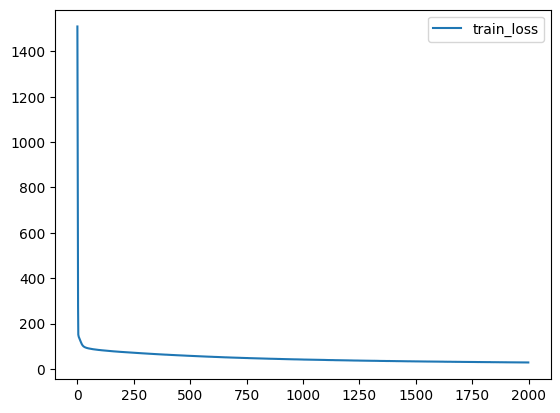

In [629]:
from matplotlib import pyplot as plt
plt.plot(losses, label='train_loss')

plt.legend()
plt.show

In [630]:
# pred_label = []
# true_label = []
# for batch in tqdm(testloader):
#     batch = [i.cuda() for i in batch]
#     sent_id, masks, labels = batch

#     preds = model(sent_id, masks)
#     #pred_label.extend(torch.argmax(preds, axis = 1).cpu())
#     pred_label.extend(preds.cpu())
#     true_label.extend(labels.cpu())

In [669]:
#在上面的代码中，我们首先定义了两个空列表pred_label和true_label来存储
#模型的预测标签和真实标签。然后，我们遍历测试集并对每个批次进行预测
#。将预测值和真实值添加到相应的列表中后，我们可以使用
#sklearn库中的mean_absolute_error函数来计算MAE。
#最后，我们将MAE打印出来。
from sklearn.metrics import mean_absolute_error

# pred_label = []
# true_label = []
pred_label_1 = []
pred_label_2 = []
true_label_1 = []
true_label_2 = []
for batch in tqdm(testloader):
    batch = [i.cuda() for i in batch]
    sent_id, masks, labels = batch

    preds = model(sent_id, masks)
    # pred_label.extend(preds.detach().cpu().numpy())
    # true_label.extend(labels.detach().cpu().numpy())
    pred_label_1.extend(preds[:, 0].detach().cpu().numpy())
    pred_label_2.extend(preds[:, 1].detach().cpu().numpy())
    true_label_1.extend(labels[:, 0].detach().cpu().numpy())
    true_label_2.extend(labels[:, 1].detach().cpu().numpy())

# mae = mean_absolute_error(true_label, pred_label)
mae_1 = mean_absolute_error(true_label_1, pred_label_1)
mae_2 = mean_absolute_error(true_label_2, pred_label_2)

#print(f'MAE: {mae}')

print(f'MAE for Valence: {mae_1}')
print(f'MAE for Arousal: {mae_2}')
#Ckipall2000,MAE for Valence: 0.9184504151344299,MAE for Arousal: 1.0241398811340332


100%|██████████| 81/81 [00:05<00:00, 13.65it/s]

MAE for Valence: 0.9184504151344299
MAE for Arousal: 1.0241398811340332


In [632]:
# def predict_sentiment(sentence, model, tokenizer):
#     encoded_sent = tokenizer.encode_plus(
#         sentence,
#         truncation=True,
#         max_length=50,
#         add_special_tokens=True,
#         # pad_to_max_length=True,
#         padding='longest',
#         return_attention_mask=True,
#         return_tensors='pt'
#     )
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     input_ids = encoded_sent['input_ids'].to(device)
#     attention_mask = encoded_sent['attention_mask'].to(device)

#     with torch.no_grad():
#         output = model(input_ids, attention_mask)

#     return output.item()

def predict_sentiment(sentence, model, tokenizer):
    encoded_sent = tokenizer.encode_plus(
        sentence,
        truncation=True,
        max_length=50,
        add_special_tokens=True,
        padding='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cuda'if torch.cuda.is_available() else print("gpu error"))
    input_ids = encoded_sent['input_ids'].to(device)
    attention_mask = encoded_sent['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    return output.cpu().numpy()

In [638]:
sentence = "傻逼嗎?"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你害我輸了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "可惡，你害我放槍了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "就等你這張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "不知道要出哪張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你到底會不會打牌"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "難過"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你很討厭"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你老是盯我的牌，讓我很不舒服。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我放槍了，這場遊戲讓我很失望。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "很不友善"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "太可惡了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "讓我多想想呢"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我很高興"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我高興到不行"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "生氣"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))



傻逼嗎? [[-0.83780718  1.20850849]]
你害我輸了 [[-1.6068821   2.51932192]]
可惡，你害我放槍了 [[-2.39680505  2.48695421]]
就等你這張 [[ 1.16647434 -0.3971324 ]]
不知道要出哪張 [[ 0.86020517 -1.66254497]]
你到底會不會打牌 [[-0.14633083  2.36742687]]
難過 [[-2.27206707  0.8383317 ]]
你很討厭 [[-2.44454026  1.73700237]]
你老是盯我的牌，讓我很不舒服。 [[-0.15511227  1.61408377]]
我放槍了，這場遊戲讓我很失望。 [[-0.81047773  1.13421345]]
很不友善 [[-1.94460225 -0.16902494]]
太可惡了 [[-2.14940929  2.84198809]]
讓我多想想呢 [[-0.49572611  0.79591608]]
我很高興 [[2.70600986 2.6102066 ]]
我高興到不行 [[0.74485111 3.59982014]]
生氣 [[-0.93181801 -0.00767946]]


In [656]:
#torch.save(model.state_dict(), '../DongModel/CKIPAll2000')
# model.load_state_dict(torch.load('../DongModel/CKIPAll2000'))
# model.eval()
# sentence = "胡屁胡"
# score = predict_sentiment(sentence, model, tokenizer)
# print(score)